### Introduction

During their lifetime, aircraft components
are susceptible to degradation, which affects
directly their reliability and performance.
This machine learning project will be directed to provide a framework for predict-
ing the aircraft’s remaining useful life (RUL)
based on the entire life cycle data in order
to provide the necessary maintenance behavior. Diverse regression, classification
models (KNN, Naïve Bayes, Random Forest,
SVM, etc..) are deployed and tested on the
NASA’s C-MAPSS data-set to assess the
engine’s lifetime. Please check the report for more theoretical details

<div align='center' > <img src='https://i.postimg.cc/gcvWCNHf/Turbofan-operation-lbp.png'>
 </div>

<div align='center' > Illustration of a turbofan engine </div>

Our focus will be the prediction of the
RUL of the turbofan engine considering
HPC failure and more precisely capturing
low RUL values to avoid putting the engine
on risk. 

This notebook will go through : Data inspection, Data visualization, Feature engineering, Regression, Classification and finishing with LSTM.

#### Importing initially important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
np.random.seed(34)
warnings.filterwarnings('ignore')

Note : make sure to adapt the way data is collected to your environment (If you're working on kaggle you can easily click on add data then choose nasa-cmaps data).

#### Defining features names

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

#### Importing train and validation data

FD001 subset corresponds to HPC failure of the engine.

Note: train data will be splitted to train/test sets in the modeling part.

In [3]:
dftrain = pd.read_csv('../input/nasa-cmaps/CMaps/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('../input/nasa-cmaps/CMaps/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('../input/nasa-cmaps/CMaps/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(13096, 26)

In [4]:
train = dftrain.copy()
valid = dfvalid.copy()

### Data inspection

In [5]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine).Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

In [6]:
print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


In [7]:
#Cheking the presence of Nan values 
print('Total None values in the train dataset : ',train.isna().sum())

Total None values in the train dataset :  unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


No missing value is detected

In [8]:
train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


When we inspect the descriptive statistics of unit_nr we can see the dataset has a total of 20631 rows, unit numbers start at 1 and end at 100 as expected. What’s interesting, is that the mean and quantiles don’t align neatly with the descriptive statistics of a vector from 1–100, this can be explained due to each unit having different max time_cycles and thus a different number of rows. When inspecting the max time_cycles you can see the engine which failed the earliest did so after 128 cycles, whereas the engine which operated the longest broke down after 362 cycles. The average engine breaks between 199 and 206 cycles, however the standard deviation of 46 cycles is rather big. We’ll visualize this further down below to get an even better understanding.

In [9]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


### Data visualization & Feature engineering

### Max time cycle found for each Unit

Let us see the maximum time cycle of each unit

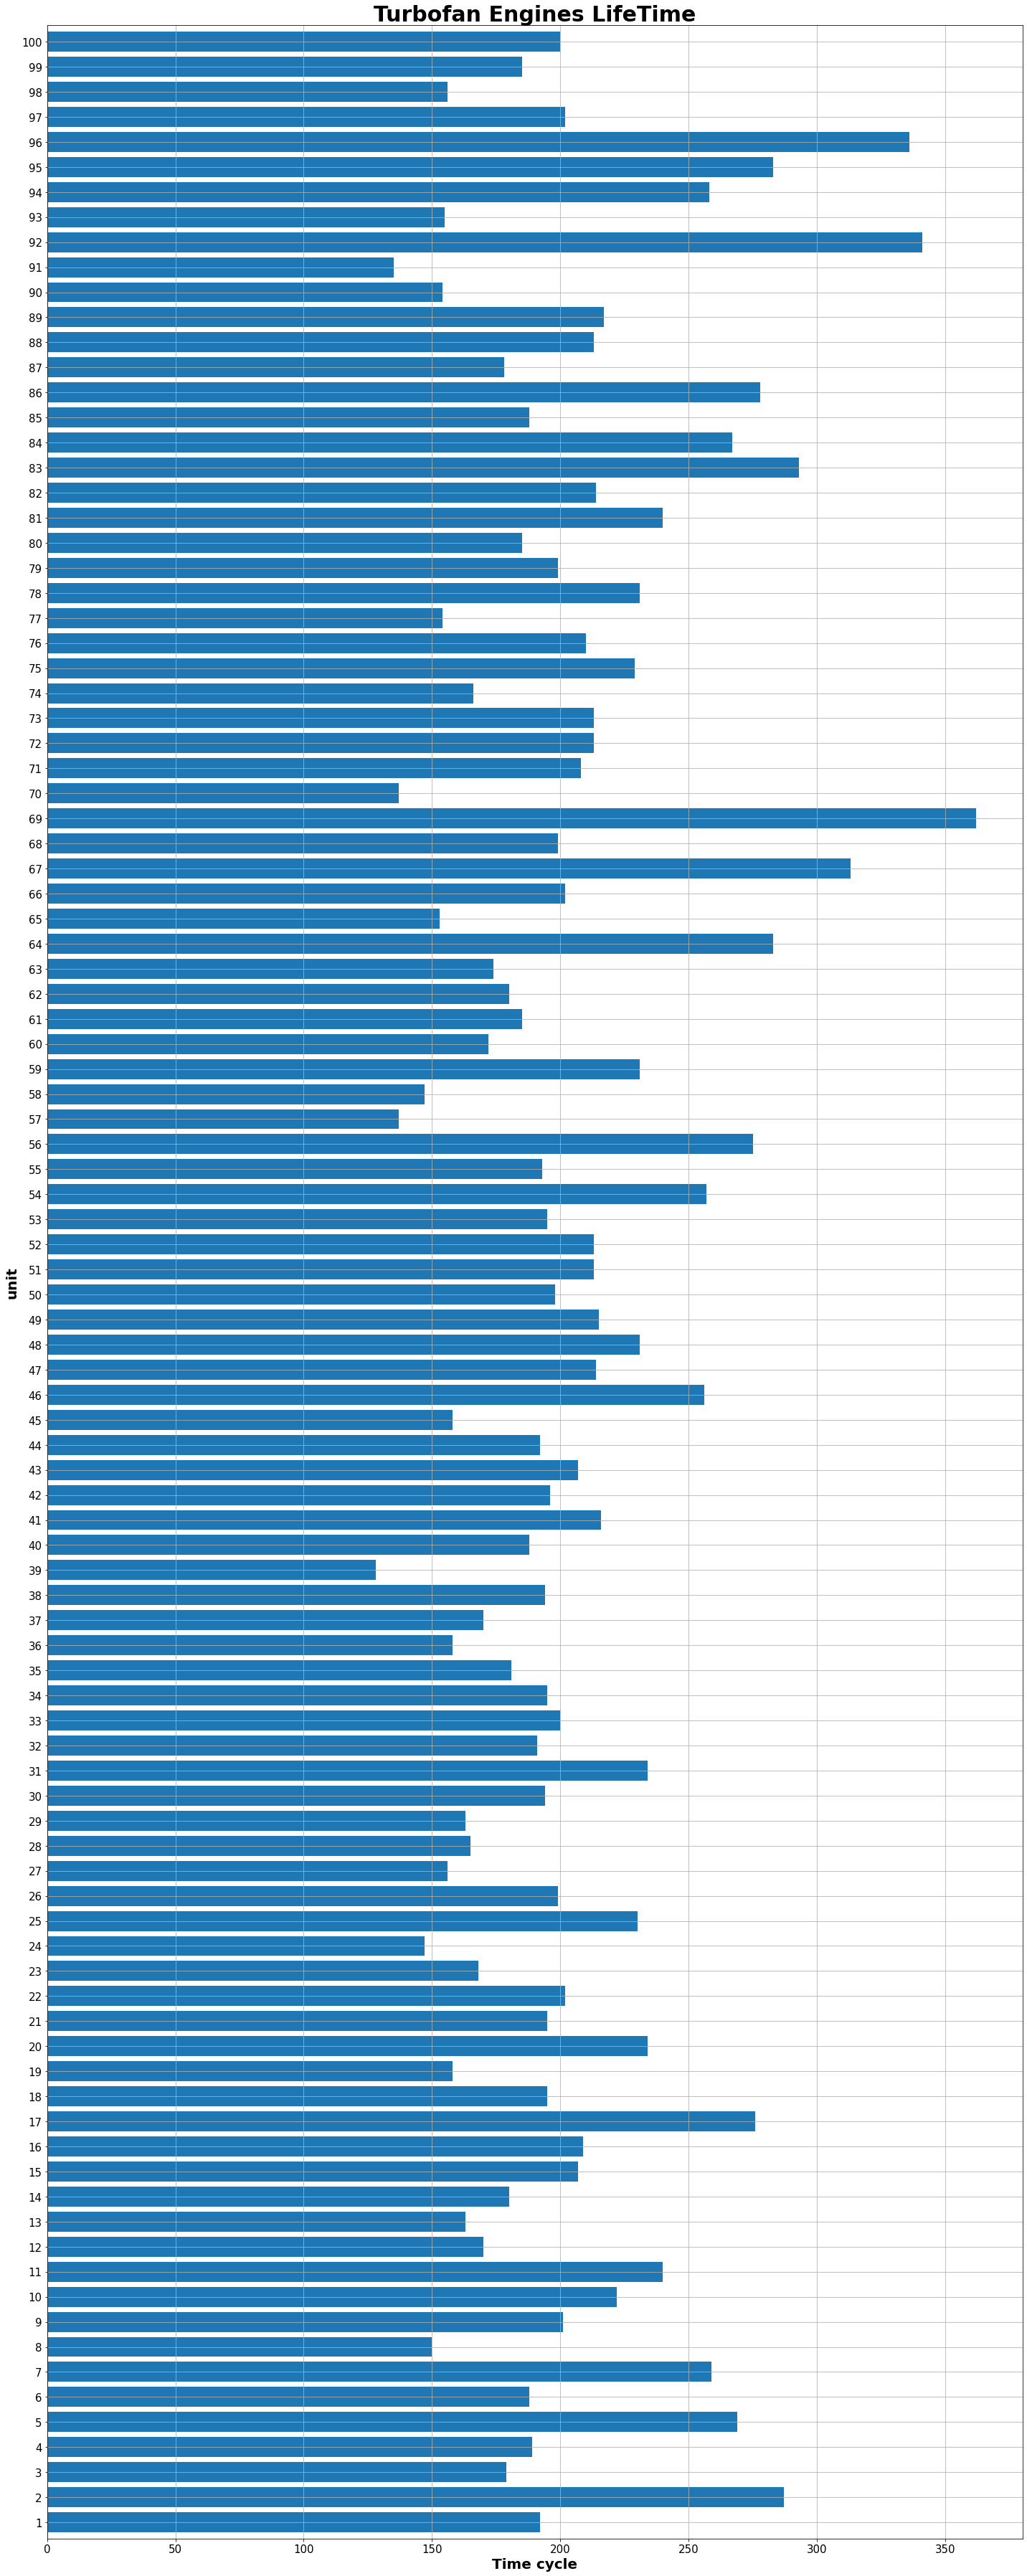

In [10]:
max_time_cycles=train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 6.800000000000011, 'max time cycle')

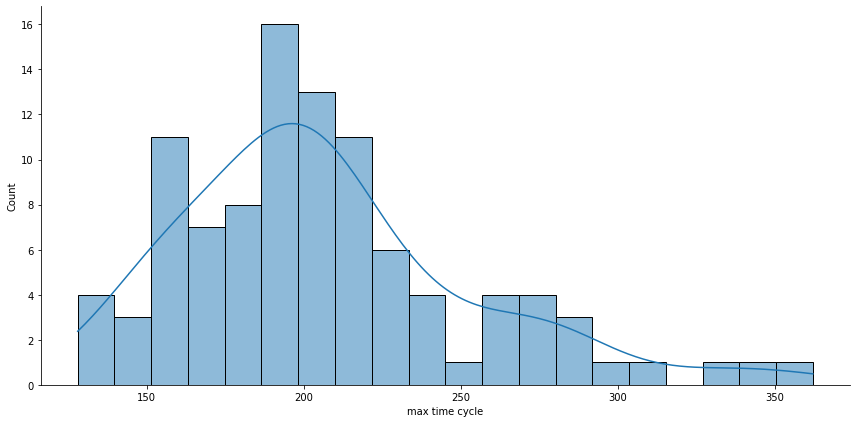

In [11]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

We notice that in most of the time, the maximum time cycles that an engine can achieve is between 190 and 210 before HPC failure.

### Add RUL column to the data

###### RUL  corresponds to the remaining time cycles for each unit before it fails.

In [12]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [13]:
train = add_RUL_column(train)

In [14]:
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


In [15]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


### Discovering Correlations 

<AxesSubplot:>

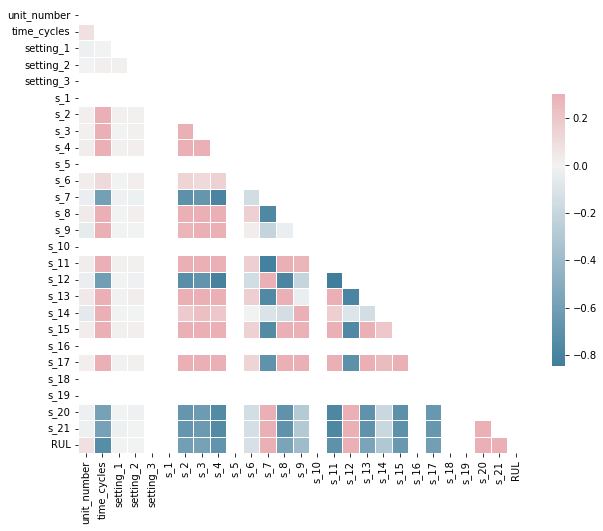

In [16]:
# Compute the correlation matrix
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

We notice that some features of our data-set are highly correlated with the target value RUL, other features present a low correlation which will be dropped later.

### Questions to answer : 

- Can we efficiently predict the remaining useful time for the engine (error significance) ?
- Which features are the most important for predicting the failure of the turbofan engine ?
- Does adding historical data improve our model ? 
- Is the collected data sufficient enough to give an accurate prediction ?
- How can we turn our problem to a classification one ?


First, let us match each sensor with its real signification

In [17]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

A **low pressure compressor (LPC**) and **high pressure compressor 
(HPC**) supply compressed high temperature, high pressure gases to the combustor.
**Low pressure turbine (LPT)** can decelerate and pressurize air to improve the chemical energy 
conversion efficiency of aviation kerosene.
**High pressure turbines (HPT)** generate mechanical energy by using high temperature and high pressure gas strike turbine blades. 
**Low-pressure rotor (N1), high-pressure rotor (N2), and nozzle** guarantee the combustion 
efficiency of the engine.

#### Plotting the evolution of features (sensors) along with the evolution with RUL

In [18]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


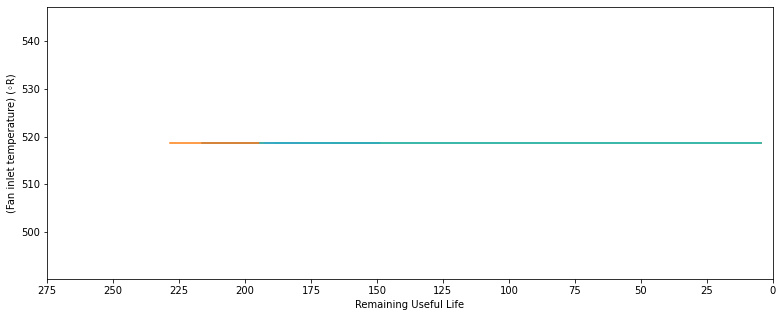

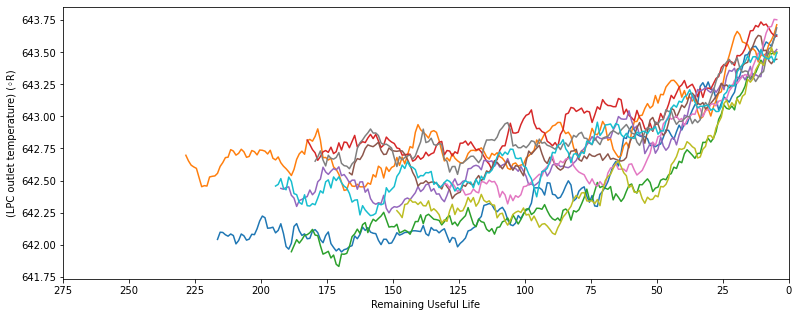

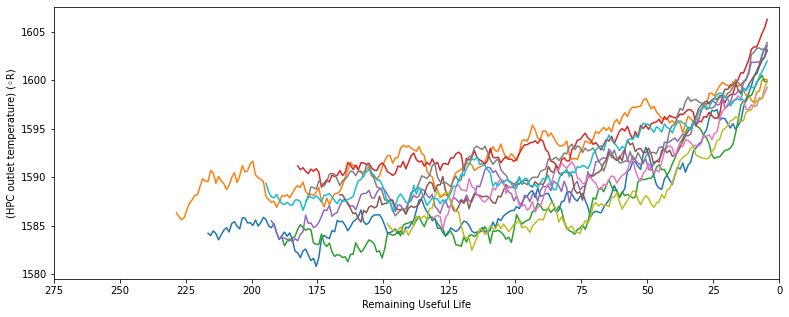

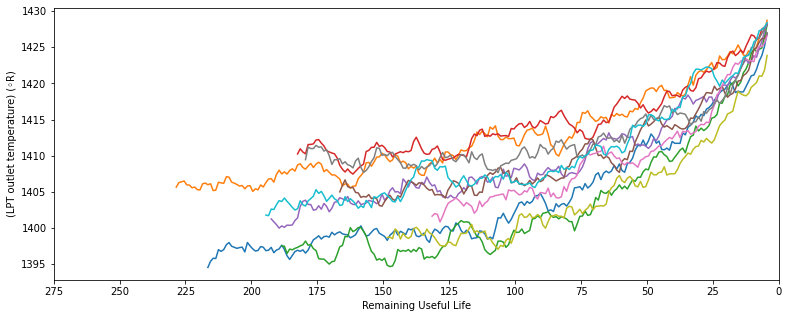

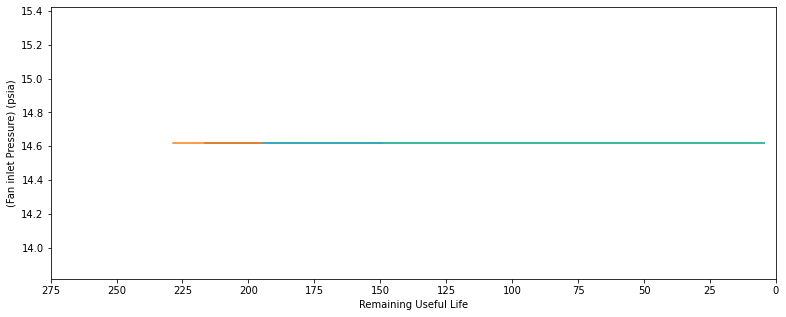

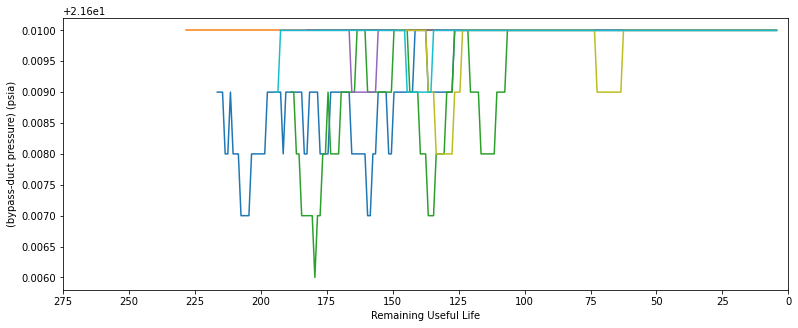

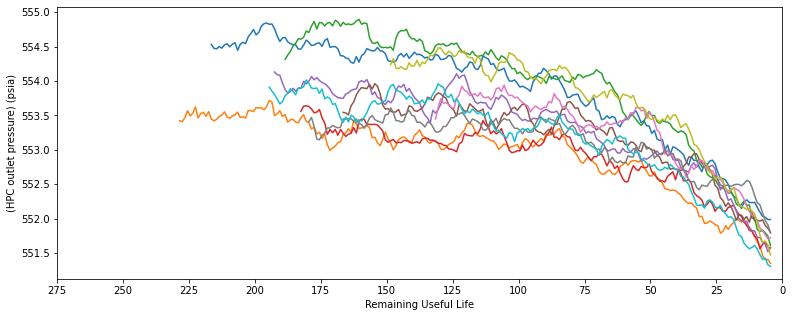

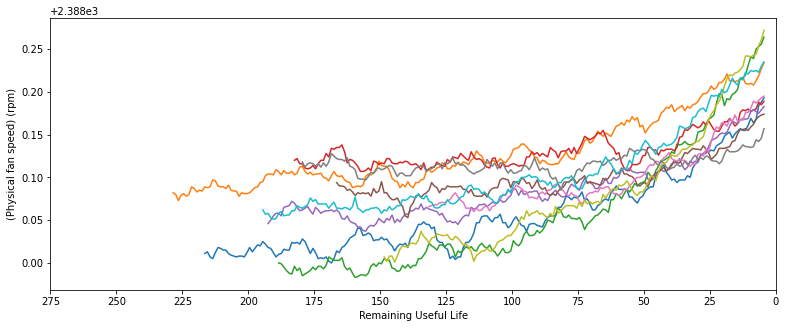

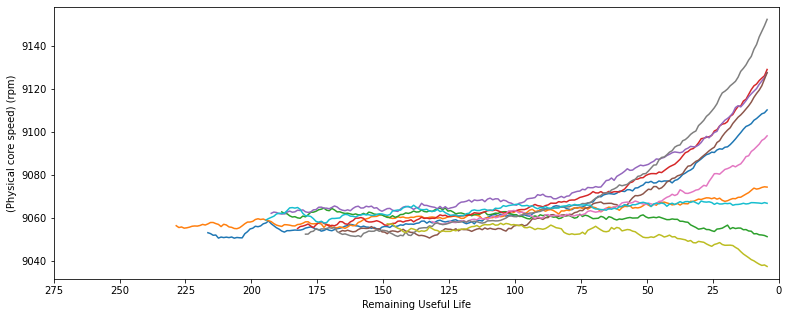

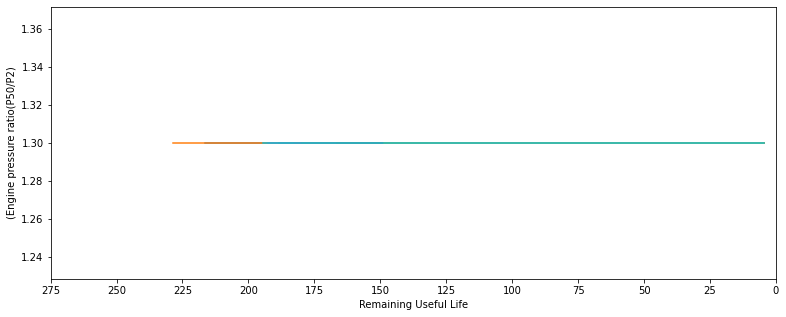

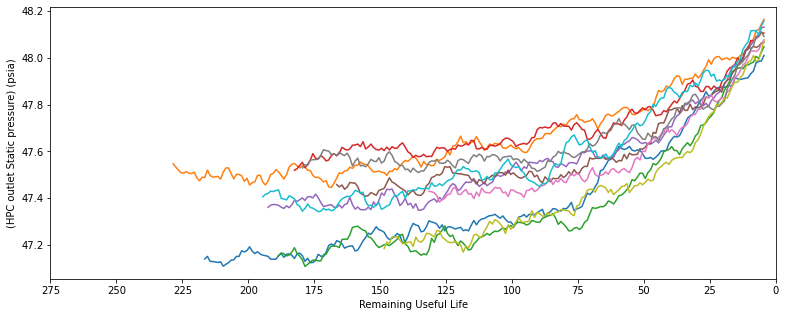

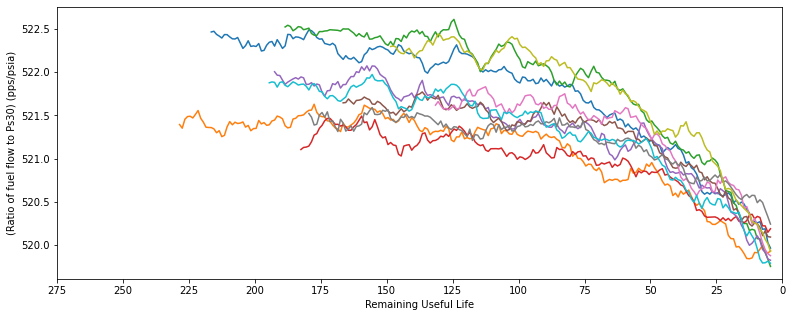

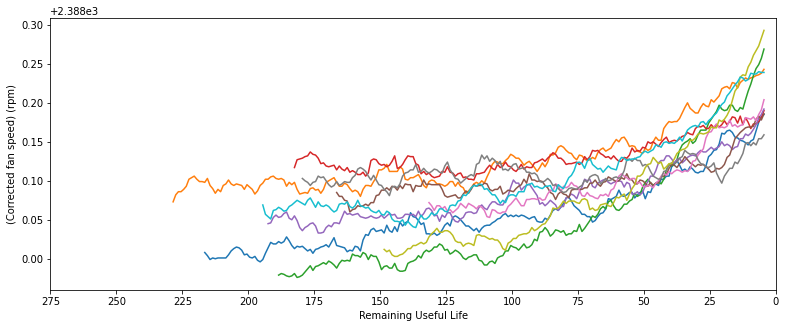

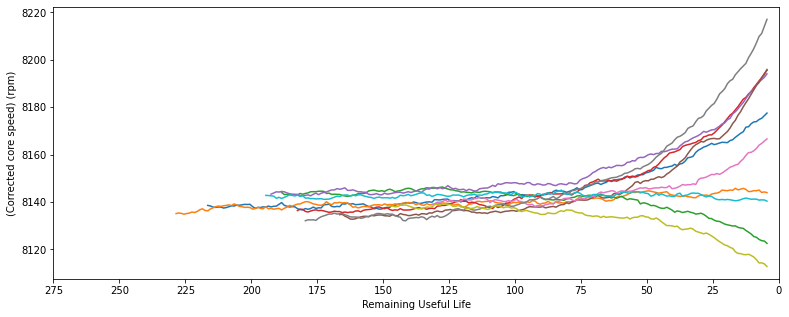

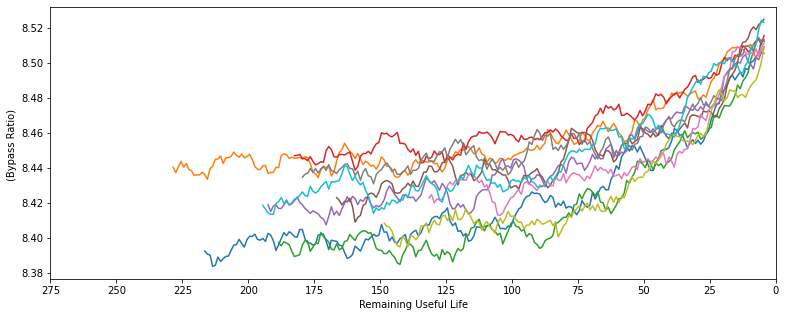

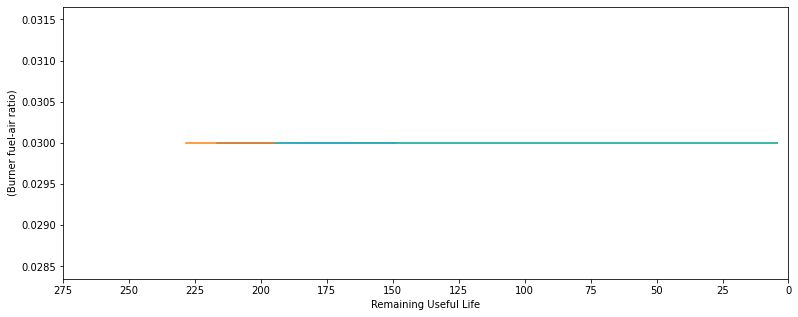

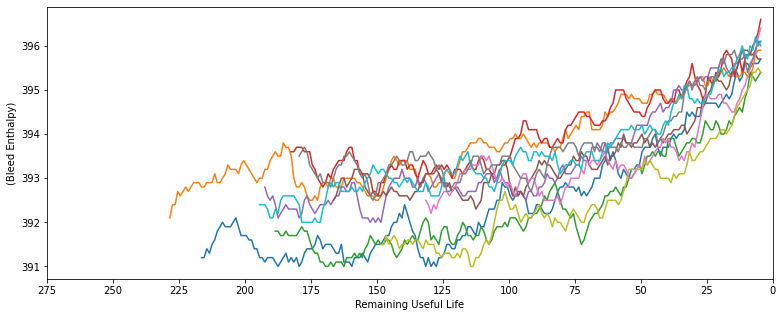

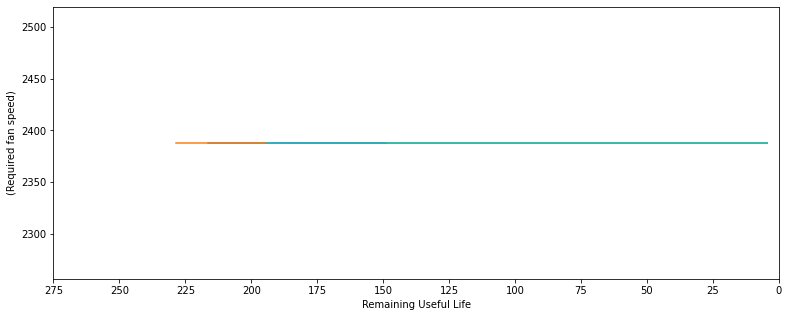

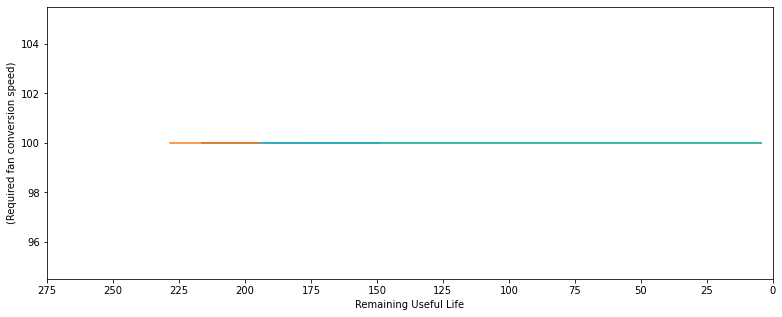

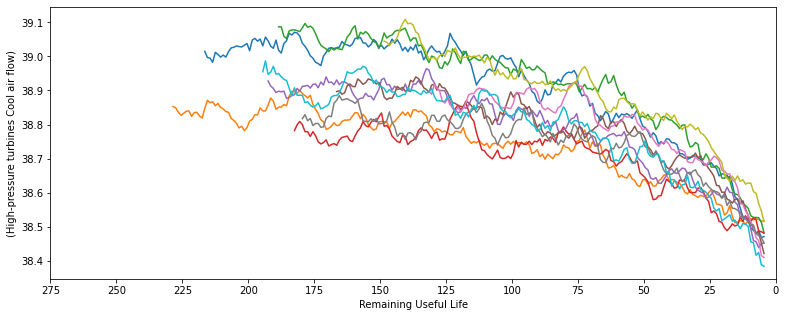

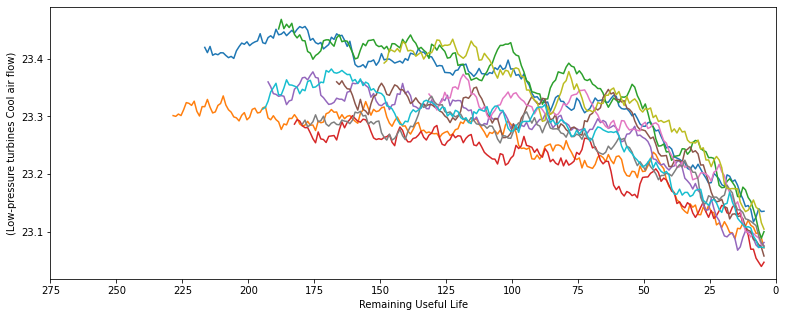

In [19]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

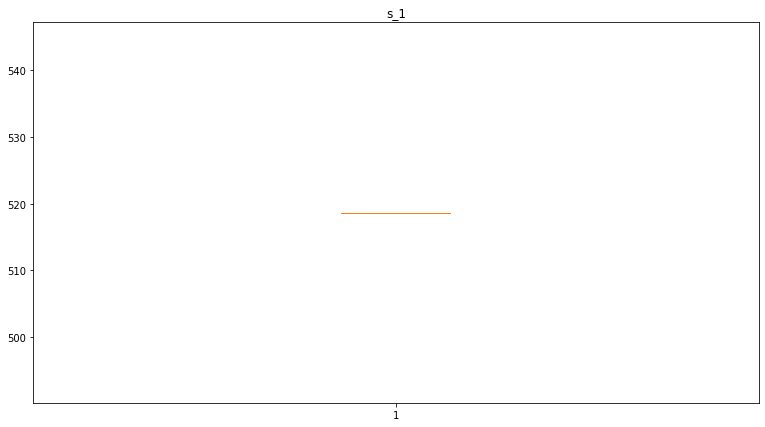

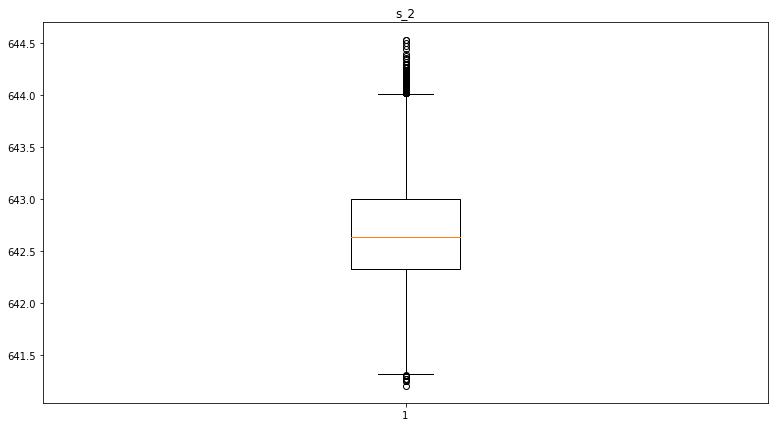

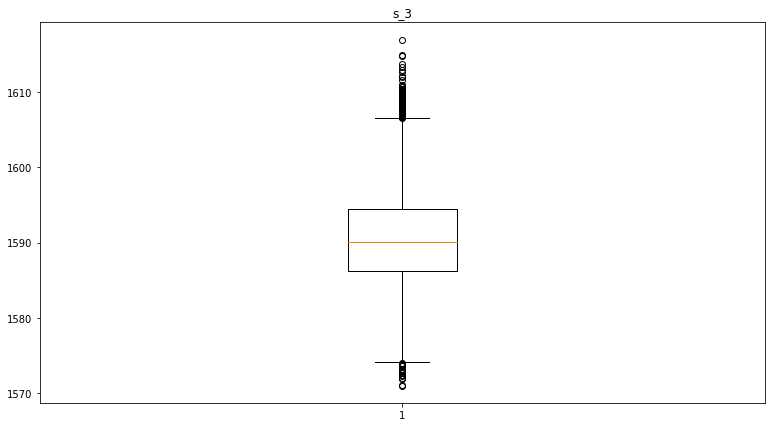

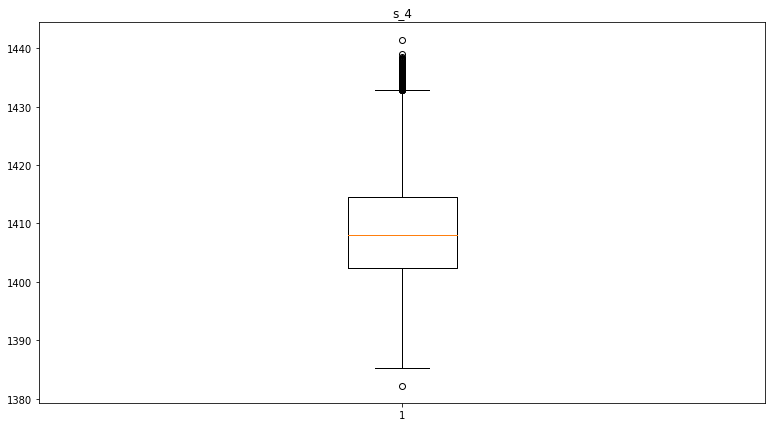

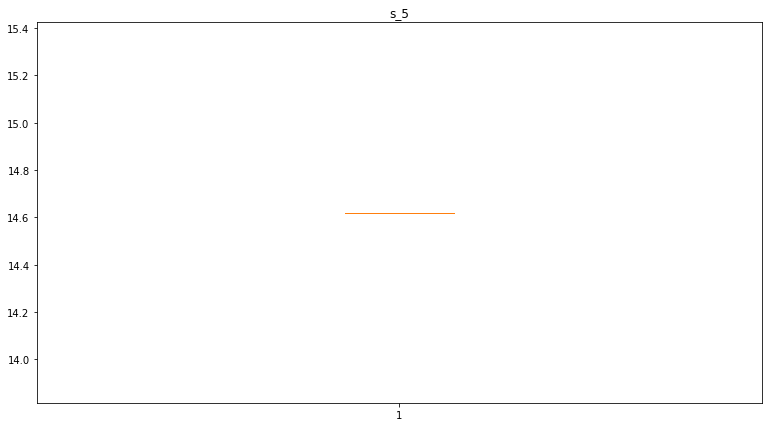

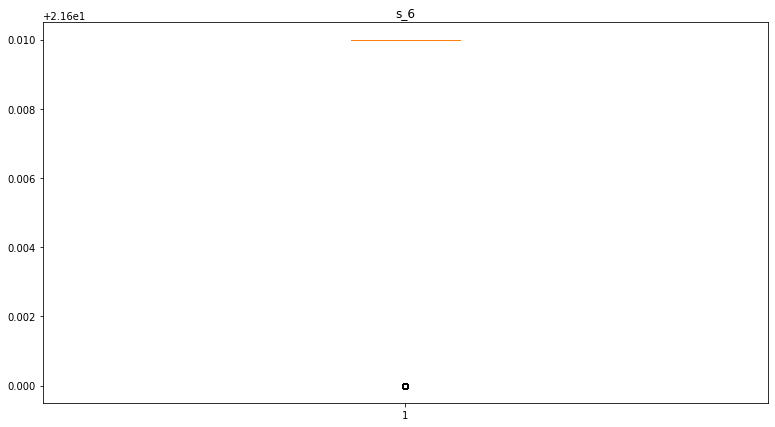

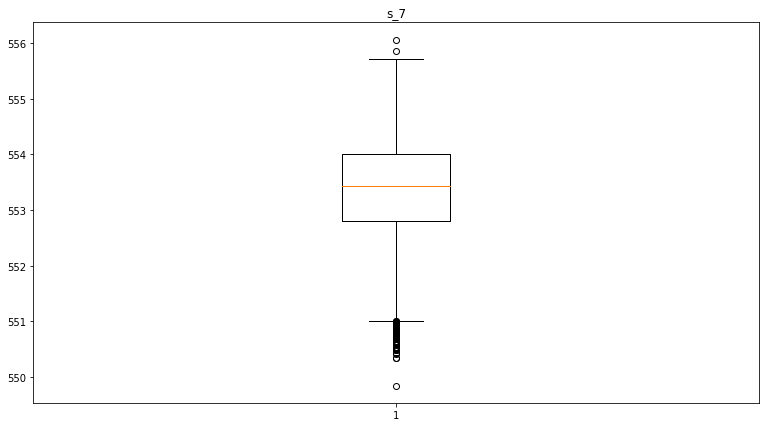

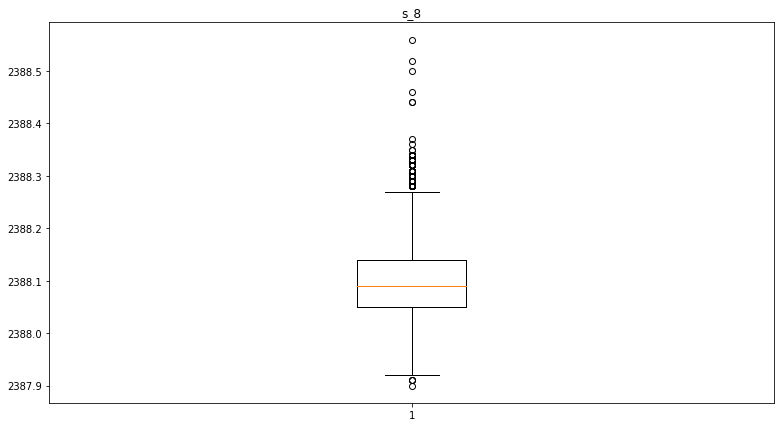

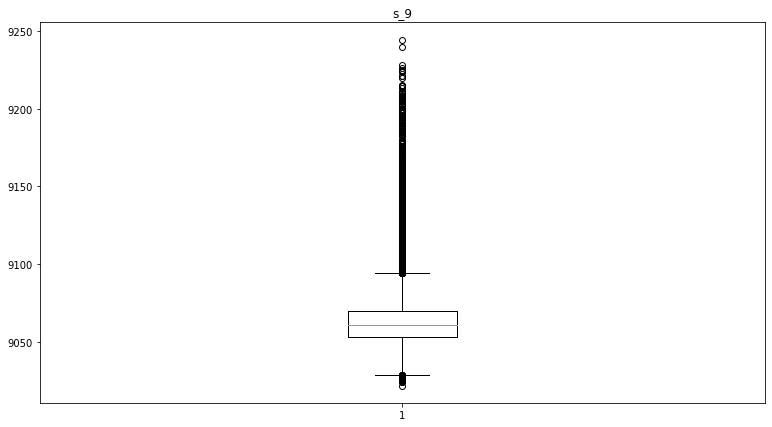

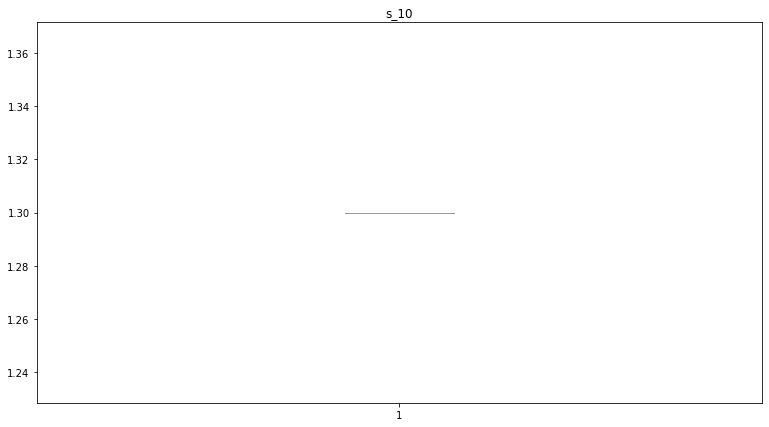

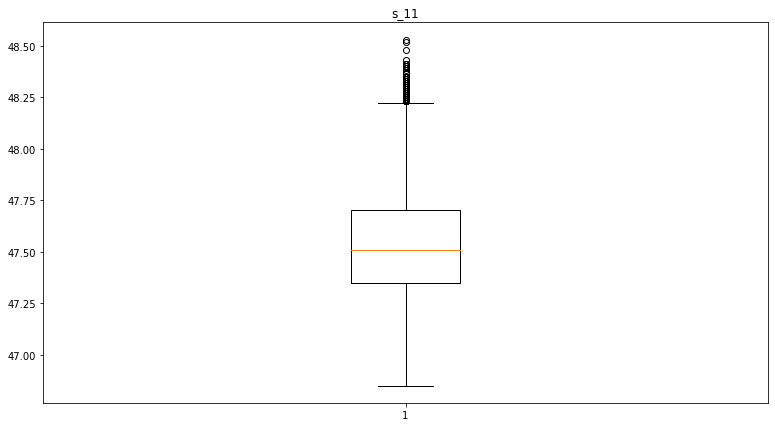

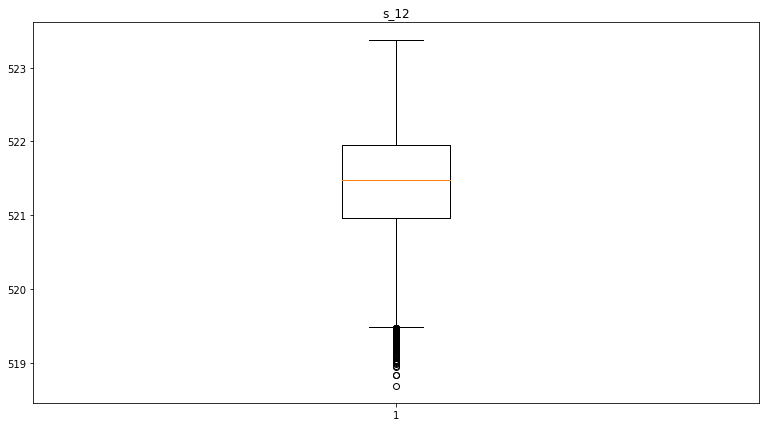

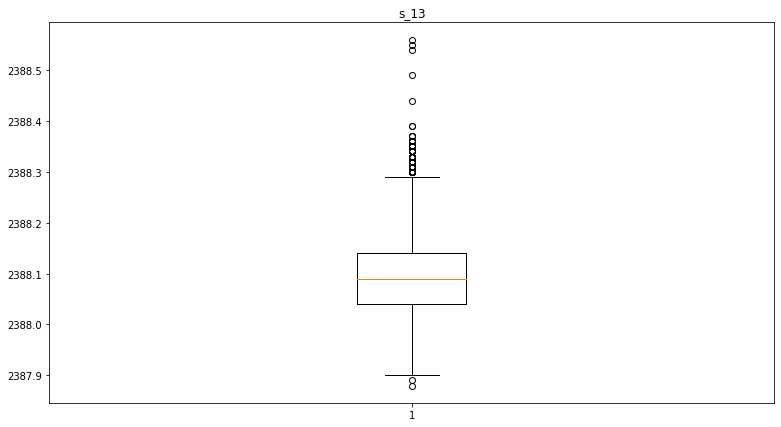

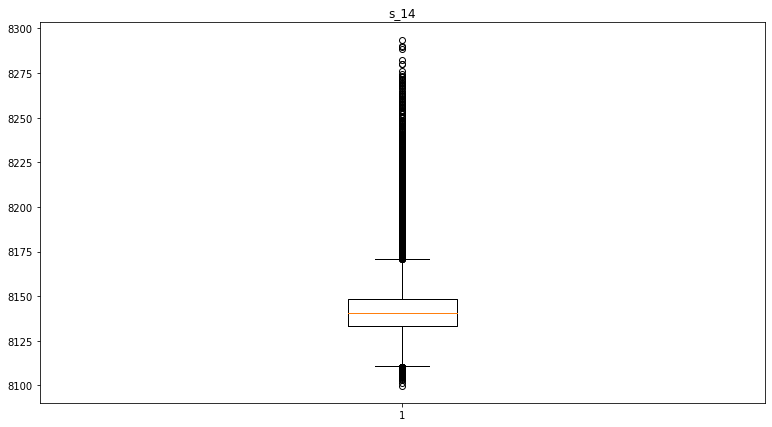

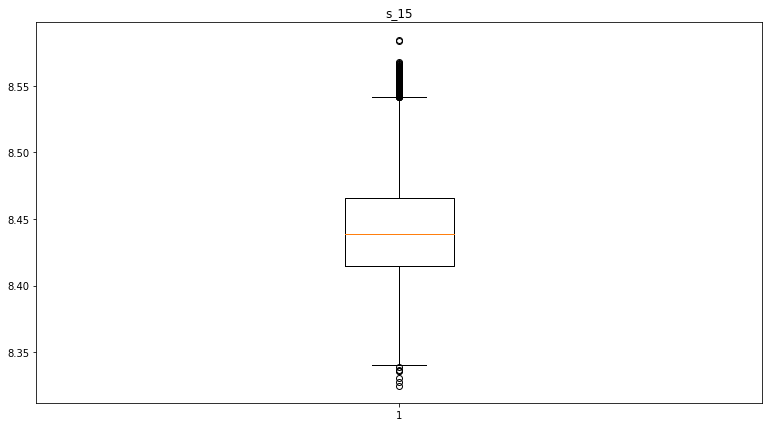

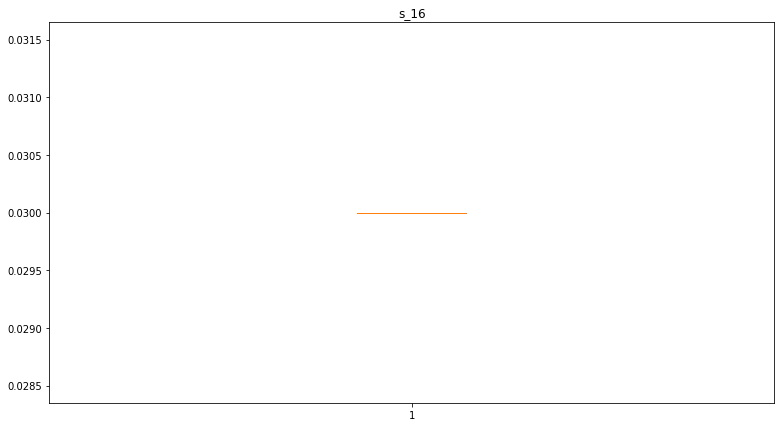

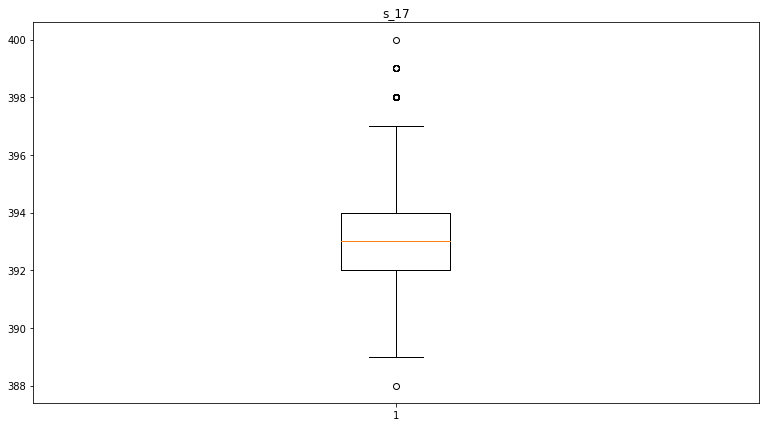

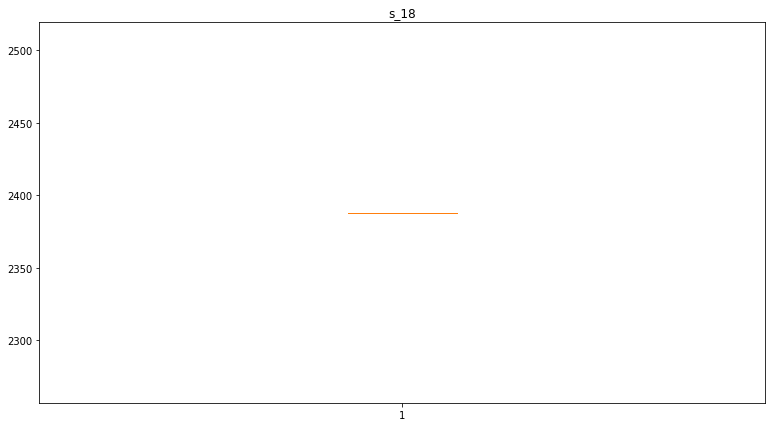

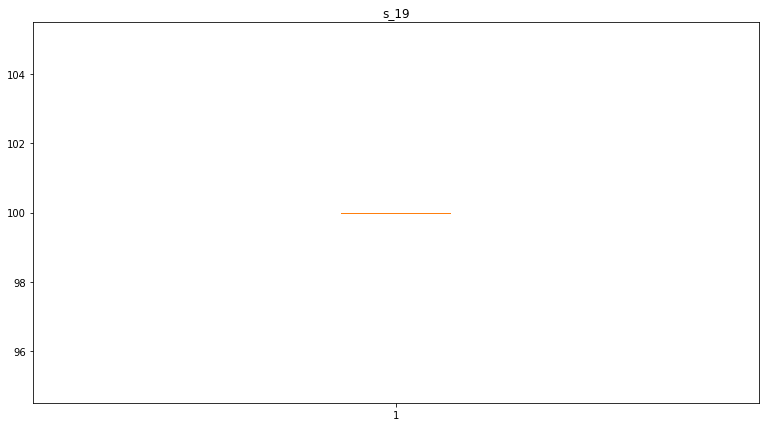

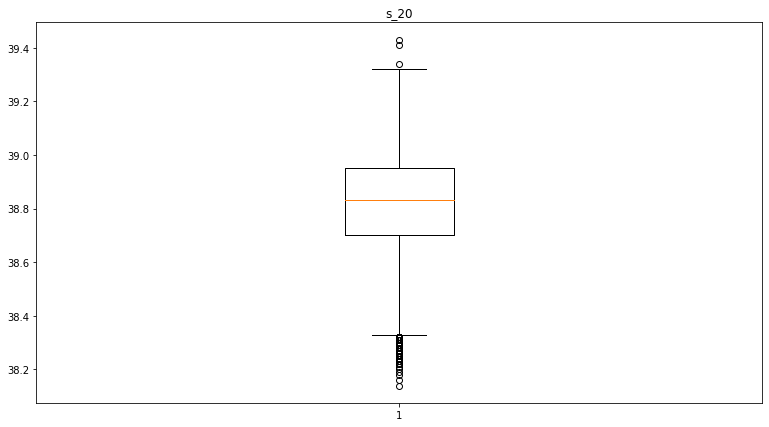

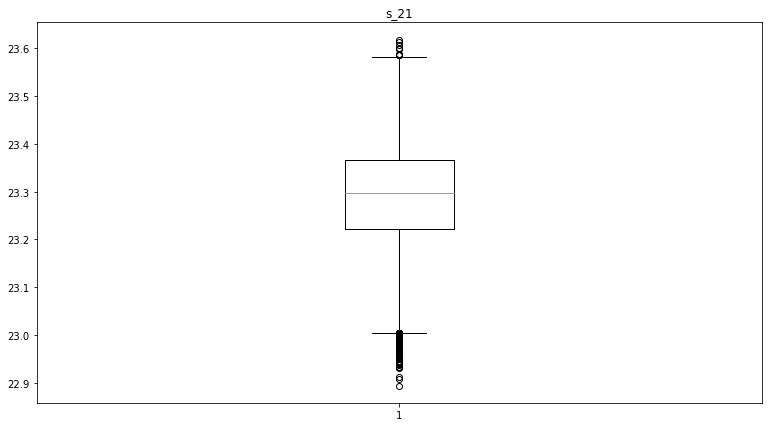

In [20]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

Observing the signal plots and the boxplots, we notice that the sensors 1,5,10,16,18,19 are constant, furthermore, we observe that the other sensors aren't well distributed and there are many outliers, then we should scale our data 

In [21]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


 The last point is more supported by the fact that the statistic properties of sensors data show that they don't have the same scale and they don't follow a normal distribution ==> this can be solved by performing a Minmax scaler on our data.

**MinMax scaler function** :Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set
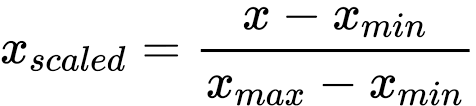!

##### Dropping unnecessary features (labels and settings)

In [22]:
from sklearn.model_selection import train_test_split
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(X_train,X_train['RUL'], test_size=0.3, random_state=42)

##### Scaling the data

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Droping the target variable
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)
#Scaling X_train and X_test
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)
#Conserve only the last occurence of each unit to match the length of y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)
#scaling X_valid
X_valid_s=scaler.fit_transform(X_valid)


In [24]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


#### plotting features new distribution

array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>,
        <AxesSubplot:title={'center':'s_7'}>],
       [<AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_9'}>,
        <AxesSubplot:title={'center':'s_11'}>,
        <AxesSubplot:title={'center':'s_12'}>],
       [<AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_14'}>,
        <AxesSubplot:title={'center':'s_15'}>,
        <AxesSubplot:title={'center':'s_17'}>],
       [<AxesSubplot:title={'center':'s_20'}>,
        <AxesSubplot:title={'center':'s_21'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

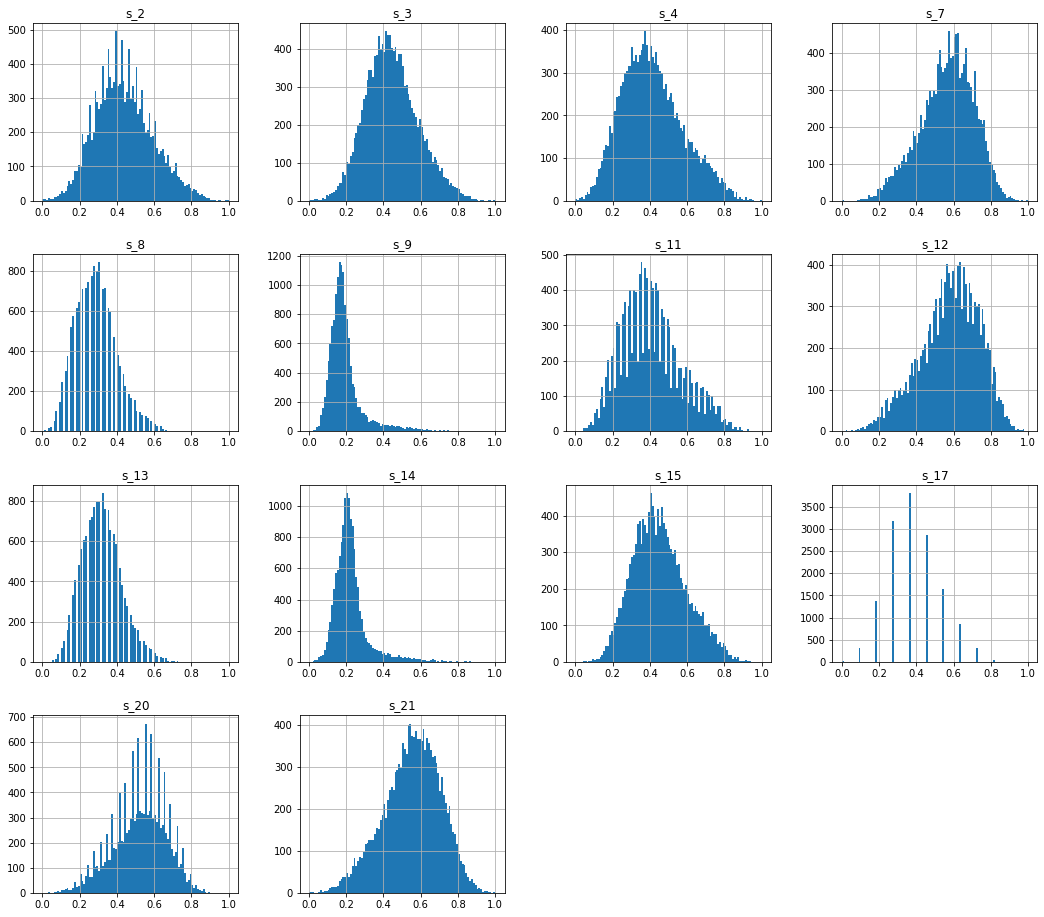

In [25]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Models Implementation and instantiation

#### Linear regression

In [26]:
class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=150 ) :    
        self.lr = lr
        self.iterations = iterations     
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p )
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning      
        for i in range( self.iterations ) :  
            self.weight_updater()
        return self
         
    def weight_updater( self ) :
        Y_pred = self.predict( self.X )  
        #  gradients  
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self
          
    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b
     
  

#### SVR

In [27]:
from sklearn.svm import SVR
import tensorflow as tf
regressor = SVR(kernel='rbf')

#### Random forest

In [28]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)


### Defining evaluation functions

In [29]:
#R2 score & RMSE & MAER
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [30]:
#plot real data and the predicted one to make some comparison
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### 1st attempt (all features, without historical data)

#### Linear regresssion

In [31]:
lr=Linear_Regression() #Instantiation
lr.fit(X=X_train_s, Y=y_train) #Fitting 

y_lr_train = lr.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid= lr.predict(X_valid_s) #Prediction on validation data
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:56.19869318681088, R2:0.3439361345919162
test set RMSE:54.264009074691856, R2:0.35713062175493715
valid set RMSE:34.84962228223509, R2:0.2967064952591343


### SVR

In [32]:
regressor.fit(X_train_s, y_train) # fitting

y_svr_train = regressor.predict(X_train_s) #Prediction on train data
evaluate(y_train,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) #Prediction on test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid= lr.predict(X_valid_s)  #Prediction on validation data
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:43.56448464126648, R2:0.605761670162996
test set RMSE:47.26718449996112, R2:0.5122262167433573
valid set RMSE:34.84962228223509, R2:0.2967064952591343


#### Random forest regressor

In [33]:
# gridsearch goes here
rf.fit(X_train_s, y_train)
# predict and evaluate
y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.408303170220156, R2:0.9506822432050425
test set RMSE:44.36383009860364, R2:0.5703082128383993
valid set RMSE:30.653618024631285, R2:0.45586841183607596


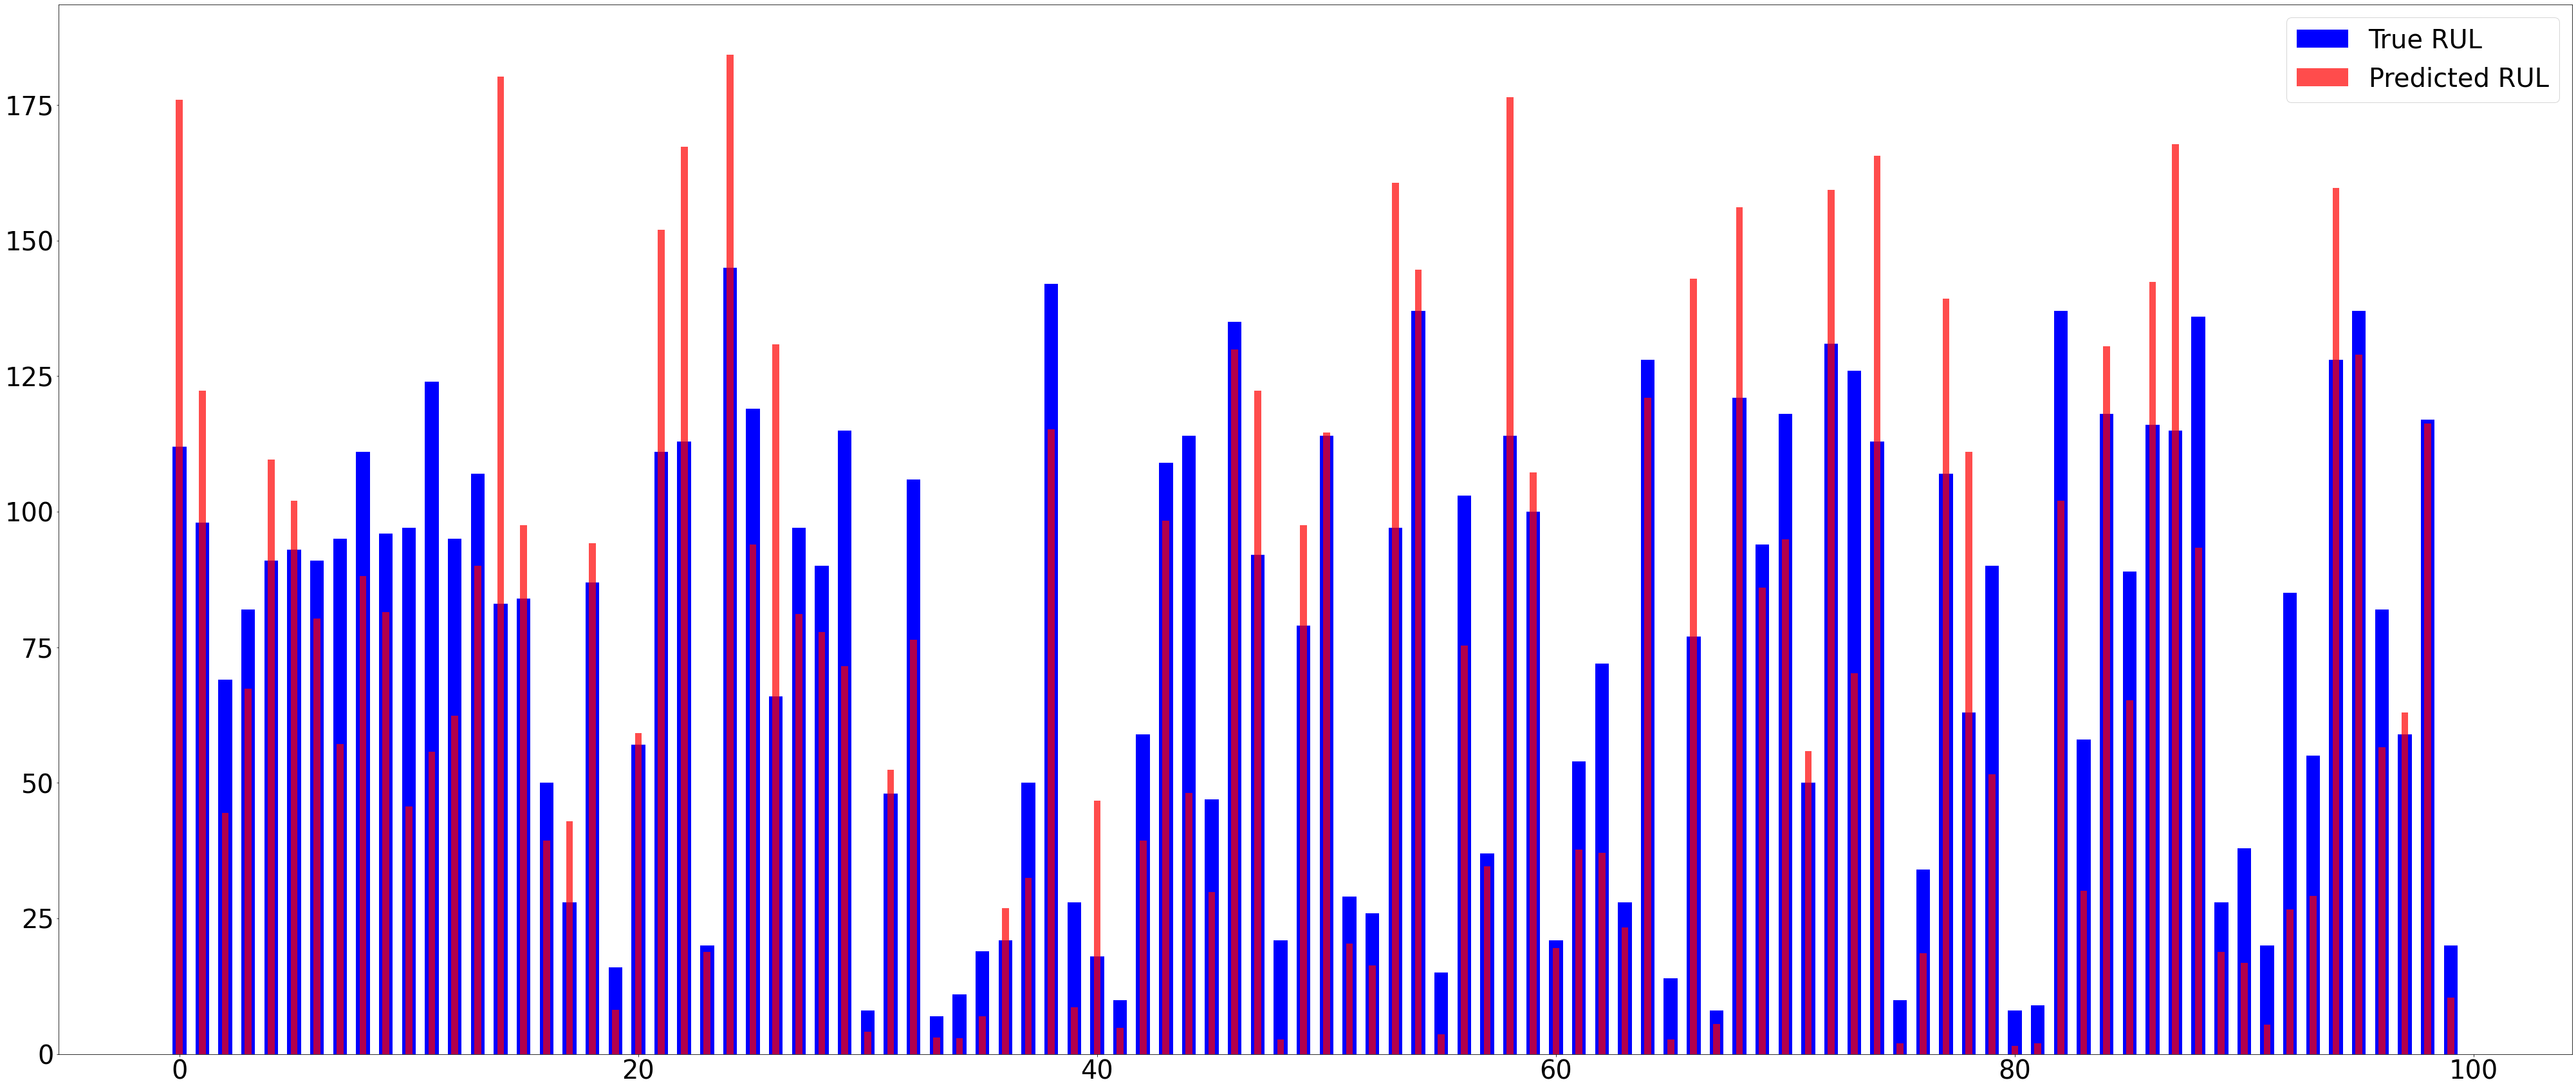

In [34]:
plot_predActual(y_valid, y_rf_valid)

We notice that the model overestimates the RUL 

### 2nd attempt (Data without useless sensors, without historical data)

In  this section we drop constant signals, and we noticed in the max_time_cycles plot that in most of the time the maximum value is in the interval [190,210], hence we will set the maximum RUL to 195 through RUL clipping,

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [35]:
print('maximum of y_train : ',y_train.max())
print('maximum of y_test : ',y_test.max())
print('maximum of y_valid : ',y_valid.max())

maximum of y_train :  361
maximum of y_test :  360
maximum of y_valid :  RUL    145
dtype: int64


(array([1023., 1066., 1083., 1120.,  937.,  557.,  237.,  117.,   35.,
          15.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

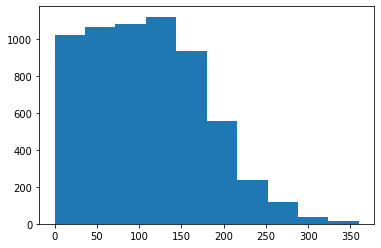

In [36]:
plt.hist(y_test)

In [37]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2=X_train.drop(columns=drop_labels2, axis=1) # drop the constant columns from the train dataset
X_test_2=X_test.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the test dataset
X_train_2_s=scaler.fit_transform(X_train_2) #scaling X_train_2
X_test_2_s=scaler.fit_transform(X_test_2) #scaling X_test_2
y_train_clip=y_train.clip(upper=195)  #Clipping y_train to have 195 as the maximum value 
X_valid_2=X_valid.drop(columns=drop_labels2, axis=1)  # drop the constant columns from the validation dataset
X_valid_2_s=scaler.fit_transform(X_valid_2) #scaling X_valid_2

###  Linear Regression

In [38]:
lr=Linear_Regression()
lr.fit(X=X_train_2_s, Y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:47.86312955545103, R2:0.3792662465007206
test set RMSE:55.6261002397046, R2:0.3244519972933424
valid set RMSE:34.21070108960351, R2:0.3222579927041398


### SVR

In [39]:
regressor.fit(X_train_2_s, y_train)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:32.91543148706822, R2:0.7064363470171213
test set RMSE:48.75516379159361, R2:0.48103242301470384
valid set RMSE:25.947912225366206, R2:0.6101071274546097


### Random forest

In [40]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:12.036862499525814, R2:0.9607418547981479
test set RMSE:45.81838291793876, R2:0.5416697719315231
valid set RMSE:26.548403567823055, R2:0.5918523714819


In [41]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip,y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:35.70696026075914, R2:0.654531114904072
test set RMSE:49.912498111969036, R2:0.4561018273422788
valid set RMSE:25.724617971451206, R2:0.6167886852735663


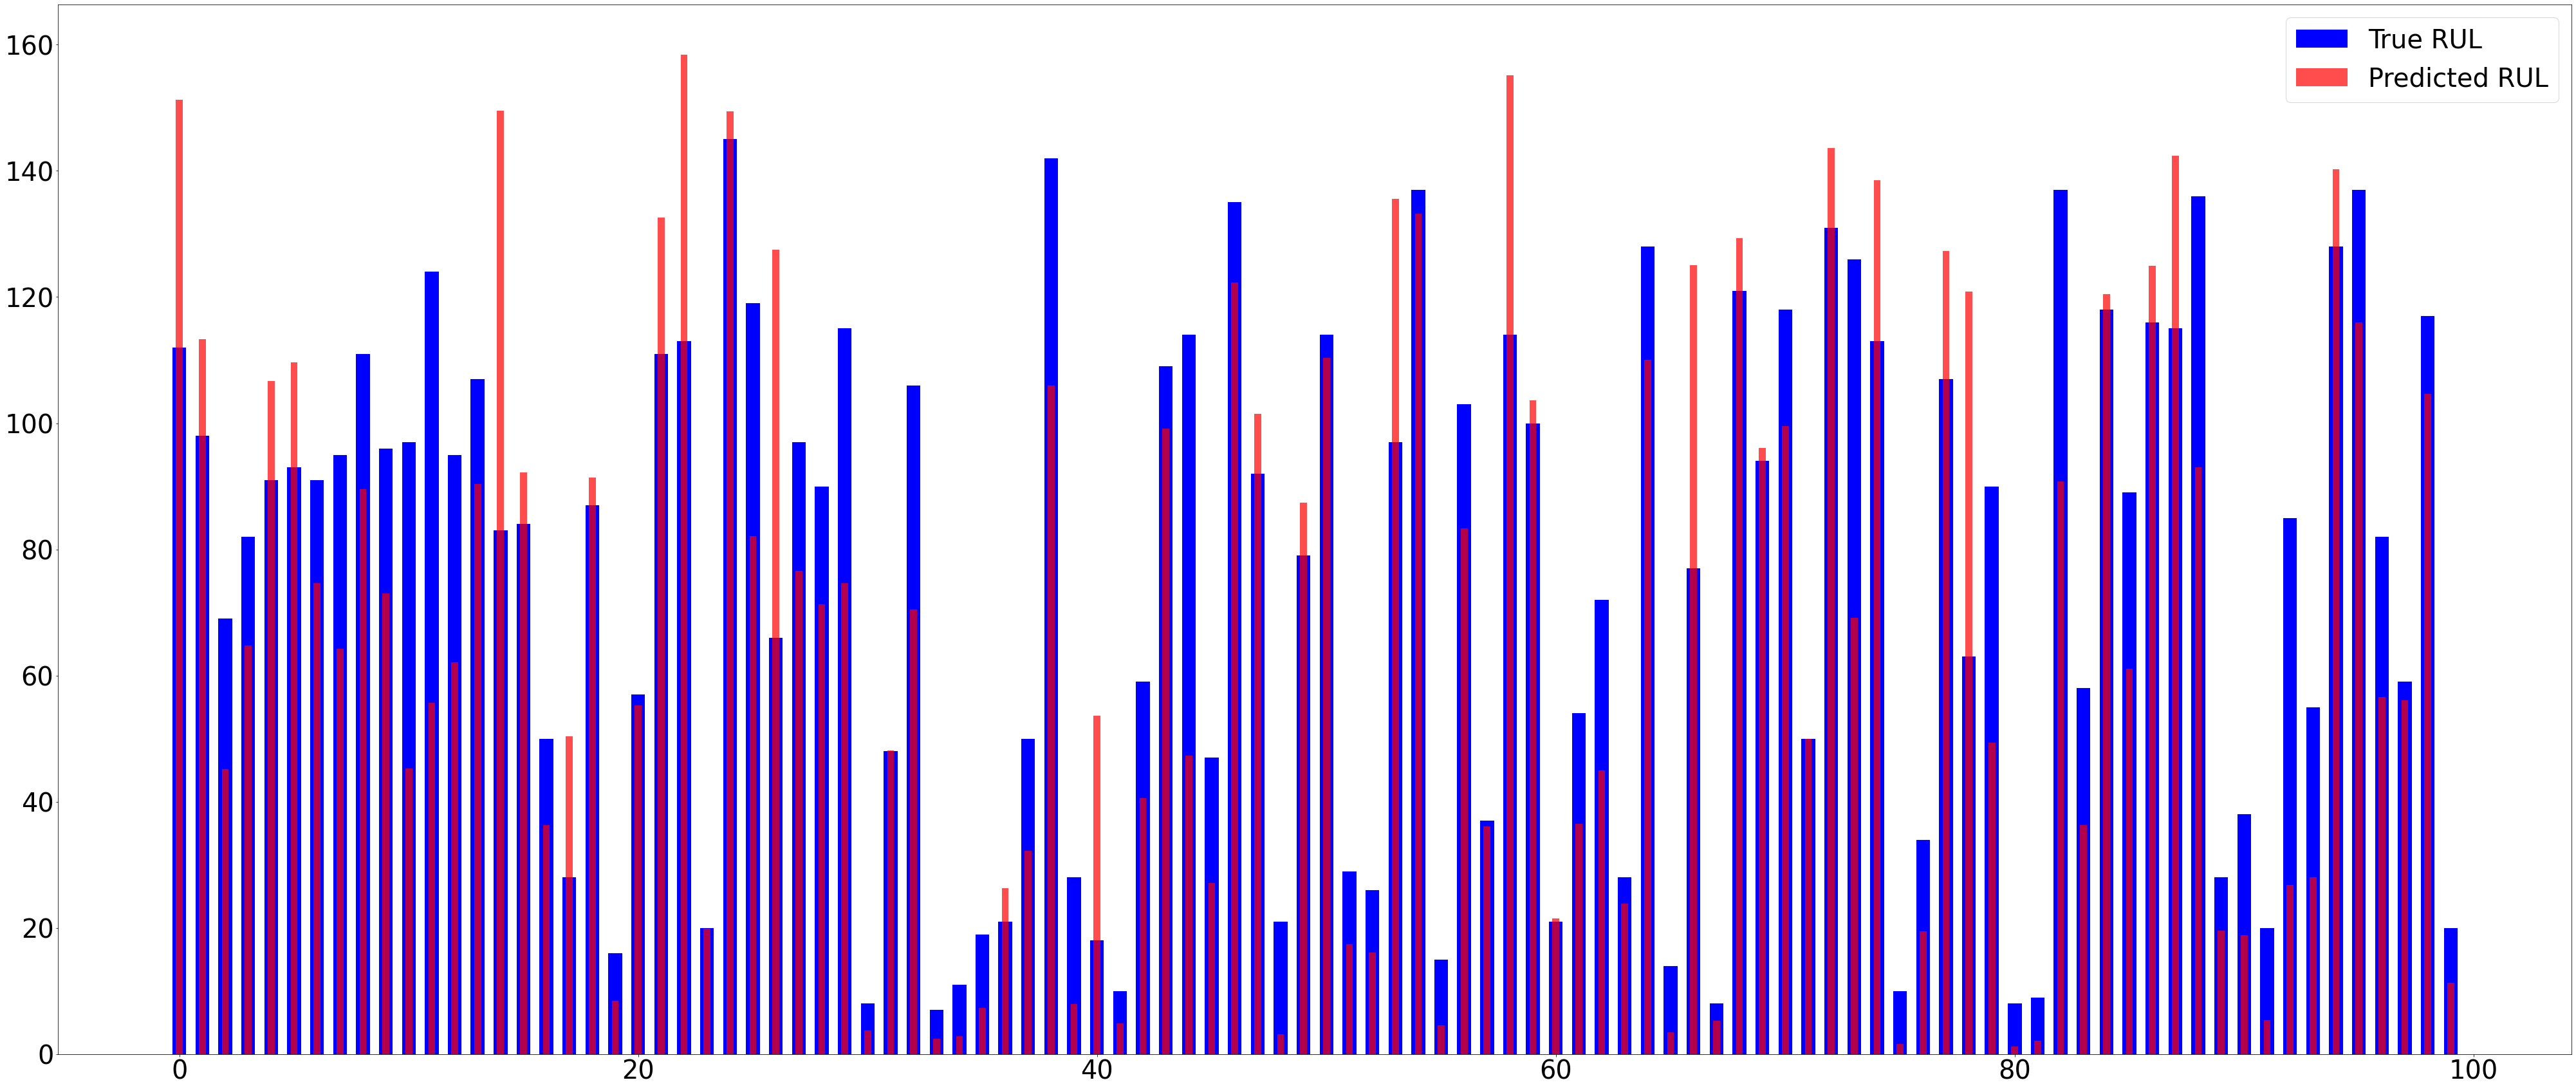

In [42]:
plot_predActual(y_valid, y_rf_valid)

### 3rd attempt (Data without useless sensors, with historical data)

In this section we are trying to discover a time series pattern in our features as we add to our data a new feature called 'rolling mean feature'. It's a equivalent to the mean value of a feature considering 10 time cycles. It will be computed for every feature.

In [43]:
df=train.copy()
for x in X_train_2.columns:
    df[x+'_rm']=0

    
df.columns



Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [44]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
df=df.drop(columns=setting_names+drop_labels2+['RUL'], axis=1)

X_valid_3=valid.drop(columns=index_names+setting_names+drop_labels2, axis=1)

In [45]:
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):
        for x in X_train_2.columns:
            data.loc[group.index[10:], x+"_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            data.loc[group.index[:10], x+"_rm"] = data.loc[group.index[:10], x]

update_rolling_mean(df, df)
update_rolling_mean(X_valid_3, valid)

X_valid_3=X_valid_3.fillna(0)

dealing with last line problem

In [46]:
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

Saving the modified data-set.

In [47]:
train_tm=df

In [48]:
train_tm=train_tm.drop(columns=index_names, axis=1)

In [49]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'].clip(upper=195), test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([valid['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

#### Models evaluation ( rmse, r2, features importance)

Linear regression

In [50]:
lr=Linear_Regression()
lr.fit(X_train_tm_s, y_train_tm)

y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:40.529140113375824, R2:0.5544980153774888
test set RMSE:40.0989396737232, R2:0.5545324354987834
valid set RMSE:38.39141884713507, R2:0.14648967061777074


SVR

In [51]:
regressor.fit(X_train_tm_s, y_train_tm)

y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:32.48452364307428, R2:0.7138011601047023
test set RMSE:33.82872041899003, R2:0.6829546036019843
valid set RMSE:26.590317383722343, R2:0.5905626119267564


The model is generalized, we avoided overfitting

Random forest

In [52]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:9.787255139684294, R2:0.9740201473464815
test set RMSE:29.95828541820653, R2:0.7513524307207359
valid set RMSE:37.19248063789238, R2:0.19896637476274992


==> the model is overfitting to train/test

Performing Grid Search

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_tm_s, y_train_tm)

print(grid.best_score_ , grid.best_params_)
#max_features=5,

0.7858882061825275 {'max_depth': 10, 'n_estimators': 120}


In [54]:
rf=RandomForestRegressor(n_estimators=90,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_tm_s, y_train_tm)
# predict and evaluate
y_hat_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test, label='test')
y_hat_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:23.867485497289408, R2:0.8455001014801531
test set RMSE:30.15571767644218, R2:0.748064337874458
valid set RMSE:38.748175208952716, R2:0.1305532959618385


==> the model is overfitting to train/test

In [55]:
# Params found using Bayesian Optimisation
xgb = xgboost.XGBRegressor(n_estimators=50, 
                           max_depth=6,
                           learning_rate=0.1,
                           reg_lambda=0.02,
                           gamma=0.4,
                           random_state=42)
xgb.fit(X_train_tm_s, y_train_tm)

# predict and evaluate
y_hat_train = xgb.predict(X_train_tm_s)
evaluate(y_train_tm, y_hat_train, 'train')

y_hat_test = xgb.predict(X_test_tm_s)
evaluate(y_test_tm, y_hat_test)

y_hat_valid = xgb.predict(X_valid_s)
evaluate(y_valid, y_hat_valid, label='valid')

train set RMSE:24.299792748077127, R2:0.8398525592100936
test set RMSE:30.58551694695227, R2:0.7408316520739405
valid set RMSE:36.04940245429818, R2:0.24744785749198428


==> the model is overfitting to train/test

#### Cross Validation 

Cross validation will be performed with SVR model (best model so far) by performing multiple splits on the dataset and running the model on each proportion for every split

In [56]:
train_tm

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,...,s_8_rm,s_9_rm,s_11_rm,s_12_rm,s_13_rm,s_14_rm,s_15_rm,s_17_rm,s_20_rm,s_21_rm
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,...,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.41950,392.0,39.060,23.41900
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,...,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.43180,392.0,39.000,23.42360
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,...,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.41780,390.0,38.950,23.34420
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,...,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.36820,392.0,38.880,23.37390
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,...,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.42940,393.0,38.900,23.40440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,...,2388.224,9066.903,48.116,519.840,2388.237,8141.170,8.51031,396.0,38.453,23.09254
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,...,2388.225,9066.820,48.116,519.793,2388.237,8140.771,8.51083,395.9,38.416,23.08540
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,...,2388.223,9066.642,48.096,519.796,2388.240,8140.882,8.51915,396.2,38.424,23.07321
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,...,2388.230,9067.045,48.136,519.813,2388.239,8140.833,8.52434,396.0,38.388,23.07370


In [57]:
from sklearn.model_selection import KFold
train_tm_cv=train_tm.copy()
y=train['RUL'].clip(upper=195)
scores_train=[]
scores_test=[]
scores_validation=[]

cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm.iloc[train_index,:], train_tm.iloc[test_index,:],y[train_index], y[test_index]
    regressor.fit(scaler.fit_transform(X_train), y_train)
    y_hat_train = regressor.predict(scaler.fit_transform(X_train))
    evaluate(y_train,y_hat_train, label='train')
    y_hat_test = regressor.predict(scaler.fit_transform(X_test))
    evaluate(y_test, y_hat_test, label='test')
    y_hat_valid = regressor.predict(scaler.fit_transform(X_valid3))
    evaluate(y_valid, y_hat_valid, label='valid')



Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     6     8 ... 20618 20622 20623]
train set RMSE:32.616951327185184, R2:0.7107331535895739
test set RMSE:32.29569893152733, R2:0.7107338807781209
valid set RMSE:28.385612462016596, R2:0.5334083159239169
Index du train :  [    1     2     3 ... 20625 20627 20628] 

Index de test :  [    0     7     9 ... 20626 20629 20630]
train set RMSE:32.336008862003894, R2:0.7135645373512873
test set RMSE:33.224639534542675, R2:0.7007157227051759
valid set RMSE:26.704880038237203, R2:0.5870269429396174
Index du train :  [    0     1     2 ... 20626 20629 20630] 

Index de test :  [    3     5    10 ... 20625 20627 20628]
train set RMSE:32.37180089277653, R2:0.71478413818672
test set RMSE:32.916499549779125, R2:0.7004715606546547
valid set RMSE:28.3904820286084, R2:0.5332482140998158
Index du train :  [    0     3     4 ... 20628 20629 20630] 

Index de test :  [    1     2    13 ... 20612 20613 20619]
train set RM

### feature importance

<BarContainer object of 28 artists>

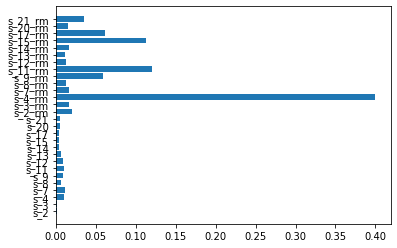

In [58]:
#BEST FEATURE FOR XGB MODEL
xgb.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, xgb.feature_importances_)

<BarContainer object of 28 artists>

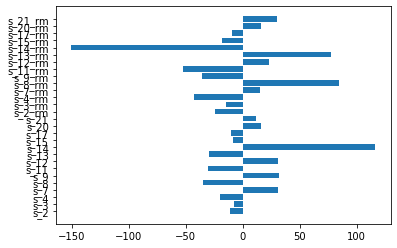

In [59]:
#BEST FEATURE FOR LINEAR REGRESSION MODEL

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=X_train_tm_s, y=y_train_tm)
plt.barh(X_train_tm.columns, model.coef_)

<BarContainer object of 28 artists>

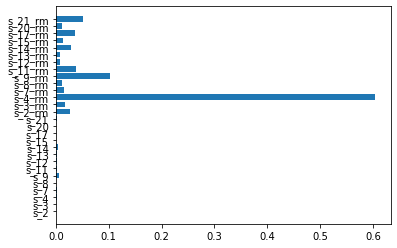

In [60]:
#BEST FEATURE FOR RF MODEL
rf.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, rf.feature_importances_)

#### Creating new df

In [61]:
dftm= pd.concat([train['unit_number'],train_tm,train['RUL']],axis=1)

In [62]:
dftm

,unit_number,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,...,s_9_rm,s_11_rm,s_12_rm,s_13_rm,s_14_rm,s_15_rm,s_17_rm,s_20_rm,s_21_rm,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,...,9046.190,47.470,521.660,2388.020,8138.620,8.41950,392.0,39.060,23.41900,191
1,1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,...,9044.070,47.490,522.280,2388.070,8131.490,8.43180,392.0,39.000,23.42360,190
2,1,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,...,9052.940,47.270,522.420,2388.030,8133.230,8.41780,390.0,38.950,23.34420,189
3,1,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,...,9049.480,47.130,522.860,2388.080,8133.830,8.36820,392.0,38.880,23.37390,188
4,1,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,...,9055.150,47.280,522.190,2388.040,8133.800,8.42940,393.0,38.900,23.40440,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,...,9066.903,48.116,519.840,2388.237,8141.170,8.51031,396.0,38.453,23.09254,4
20627,100,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,...,9066.820,48.116,519.793,2388.237,8140.771,8.51083,395.9,38.416,23.08540,3
20628,100,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,...,9066.642,48.096,519.796,2388.240,8140.882,8.51915,396.2,38.424,23.07321,2
20629,100,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,...,9067.045,48.136,519.813,2388.239,8140.833,8.52434,396.0,38.388,23.07370,1


Plotting new features 

In [63]:
def plot_signal(df, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):  
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(8).mean())

    plt.ylabel(signal_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()



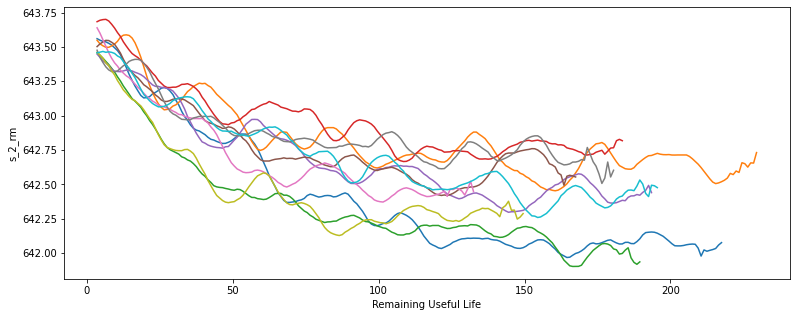

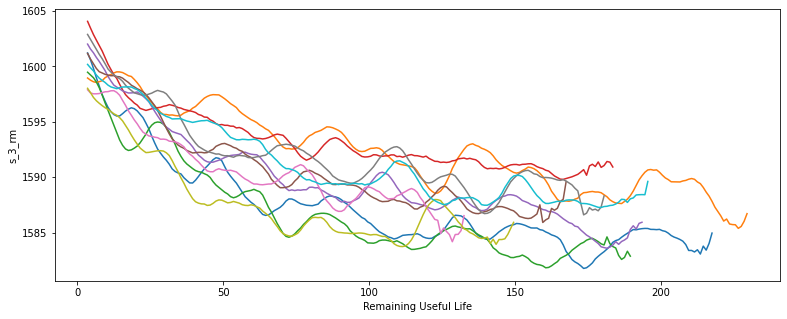

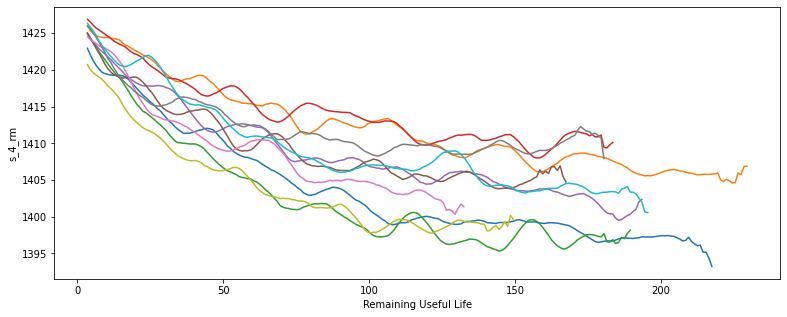

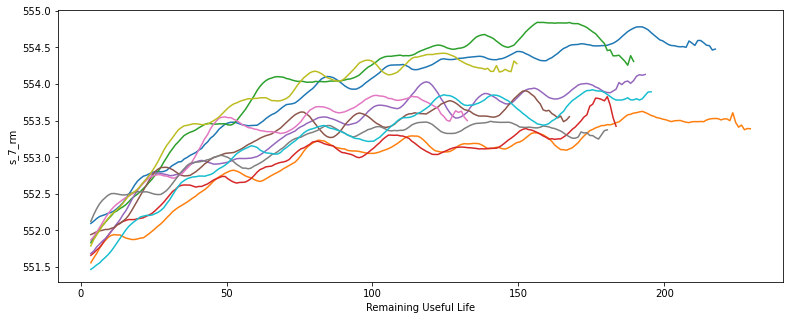

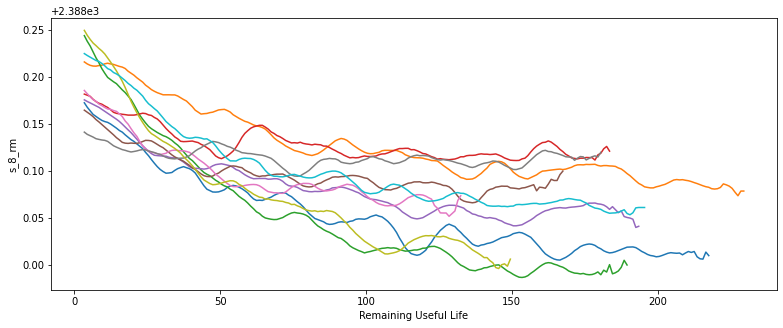

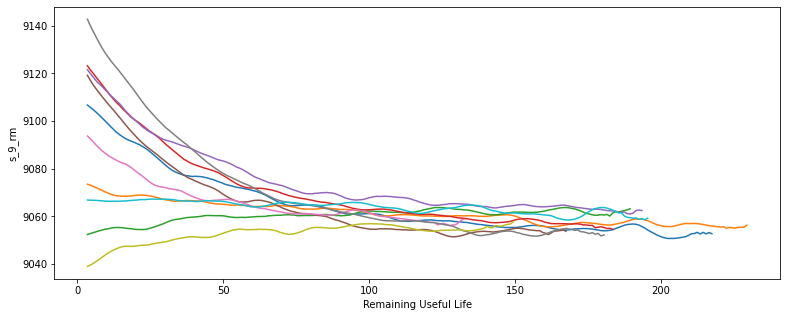

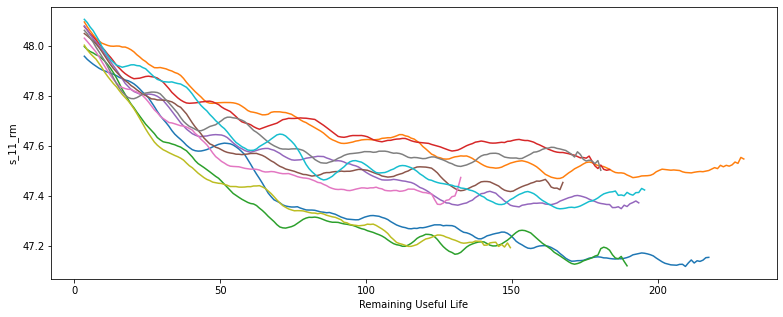

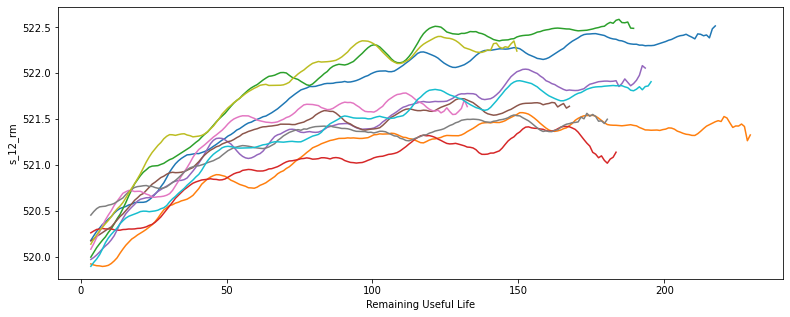

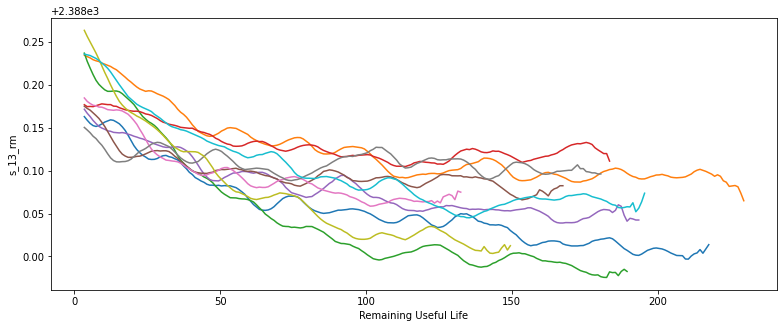

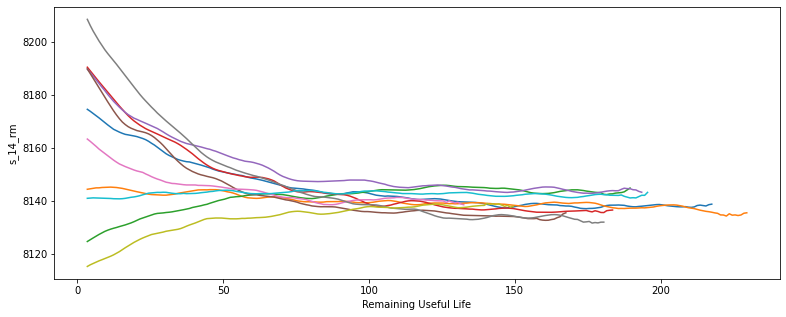

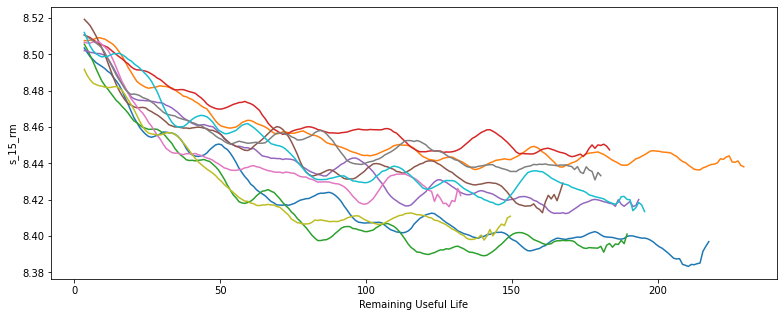

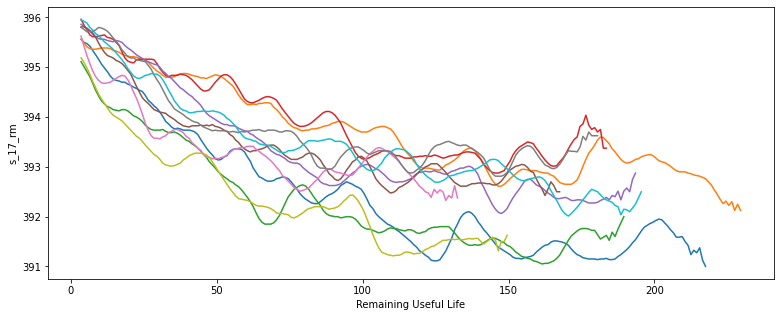

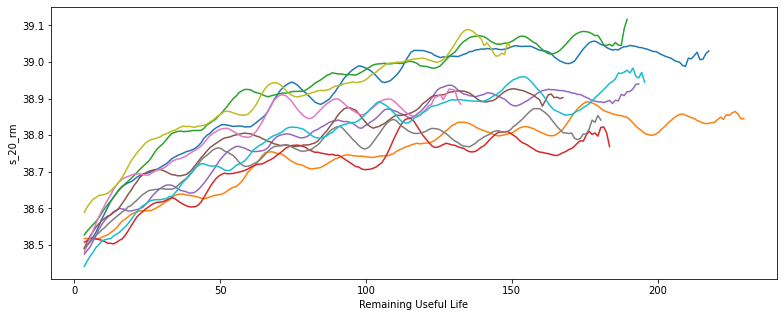

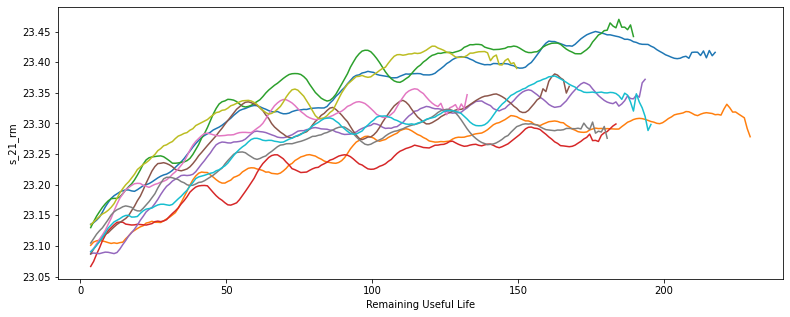

In [64]:
for i in range(1,22):
     if i not in [1,5,6,10,16,18,19] :
        try:
            plot_signal(dftm, 's_'+str(i)+'_rm')
        except:
            pass

### 

What we are seeing here is that sensors s_9, s_11, s_12 et s_7 have a significant effect on RUL.
For instance, if keep all other features constant, we notice that when the Physical core speed (represented by s_9) increases , the RUL is comparatively decreasing.

### Best Model

Judging by the difference in RMSE, we notice that SVR performs better than the other models when executed on the whole dataset.
The test RMSE obtained is 31, which will be our score to beat while running the model on the best features found so far. 

### Classification (diviser les valeurs de rul en classes)
- balanced data (2 classes / 3 classes  / 4 classes) binning
-models : random forest, svc, naive bayes, knn
- evaluation : confusion matrix, recall


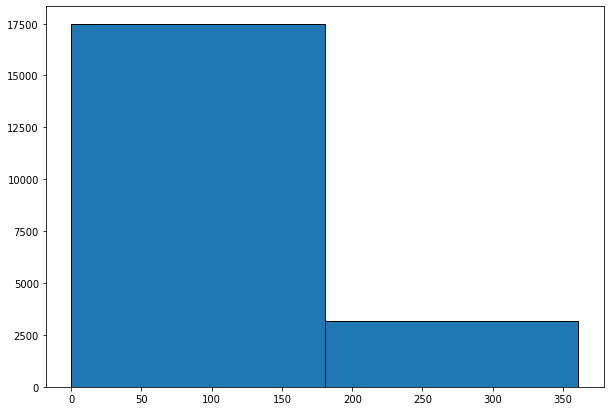

(array([17462.,  3169.]), array([  0. , 180.5, 361. ]), <BarContainer object of 2 artists>)


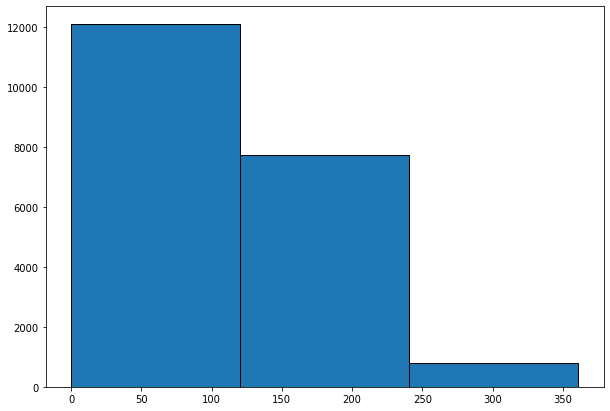

(array([12100.,  7735.,   796.]), array([  0.        , 120.33333333, 240.66666667, 361.        ]), <BarContainer object of 3 artists>)


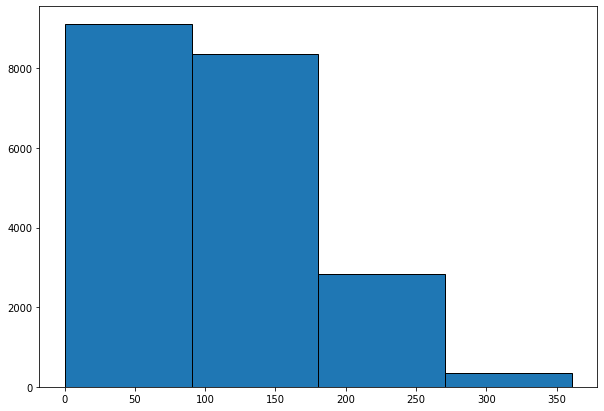

(array([9100., 8362., 2823.,  346.]), array([  0.  ,  90.25, 180.5 , 270.75, 361.  ]), <BarContainer object of 4 artists>)


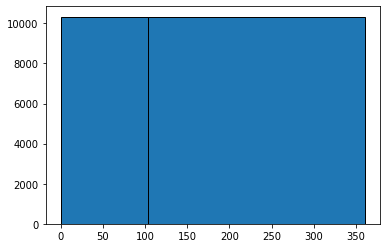

[  0. 103. 361.]


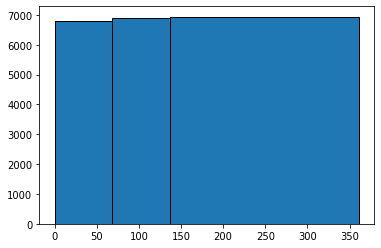

[  0.  68. 137. 361.]


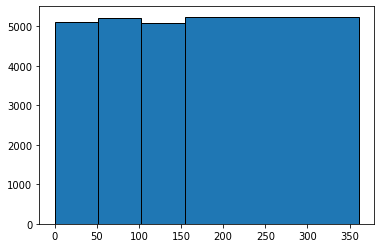

[  0.  51. 103. 155. 361.]


In [65]:
#-- fixing bins width -----
# Creating histogram of 2 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 2, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 3 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 3, edgecolor='black')
# Show plot
plt.show()
print(m)

# Creating histogram of 4 bins(same width)
fig, ax = plt.subplots(figsize =(10, 7))
m=ax.hist(list(train['RUL']), bins = 4, edgecolor='black')
# Show plot
plt.show()
print(m)



#-- fixing bins height -----

l=len(list(train['RUL']))
k=l/4

#define function to calculate equal-frequency bins, bins=2
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 2), edgecolor='black')
plt.show()
print(bins)

#define function to calculate equal-frequency bins, bins=3
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 3), edgecolor='black')
plt.show()
print(bins)


#define function to calculate equal-frequency bins, bins=4
def equalObs(x, nbin):
    nlen = len(x)
    return np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))

#create histogram with equal-frequency bins 
n, bins, patches = plt.hist(list(train['RUL']), equalObs(list(train['RUL']), 4), edgecolor='black')
plt.show()
print(bins)



####  Binning outcome demonstrated that we can create classes of RUL and turn our problem to a classification problem.
##### The priority will be given for bins that give us balanced classes
###### Let's suppose we have 3 classes of RUL 
- 1 for RUL in [0..68]    : RISK ZONE
- 2 for RUL in [69..137]  : MODERATED RISK
- 3 for RUL in [138..361] : NO RISK

##### ! Notice :  We will be working with last version of data the containing historical data (moving average) with some dropped sensors.

#### Data preparation for classification

In [66]:
y_train_tm

12276     30
8157      80
11666    103
12639    124
5278      30
        ... 
11284    107
11964    162
5390      74
860      195
15795    157
Name: RUL, Length: 13410, dtype: int64

In [67]:

label_map={1:"RISK ZONE",2:"MODERATED RISK",3:"NO RISK"}

y=[]

#--Transforming rul values to classes :
for k in dftm['RUL']:
    if k<=68:
        y.append(1)
    elif k>69 and k<=137:
        y.append(2)
    else:
        y.append(3)
X_train_tm_c, X_test_tm_c, y_train_tm_c, y_test_tm_c=train_test_split(dftm.drop(columns=['unit_number','RUL']),np.array(y), test_size=0.35, stratify=np.array(y))
X_train_tm_cs=scaler.fit_transform(X_train_tm_c)
X_test_tm_cs=scaler.fit_transform(X_test_tm_c)


#### Defining evaluation function

In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

#### Models Implementation

In [69]:
# Fit du  Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear',random_state = 1)

#### Random forest 

In [70]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#### Models evaluation

In [71]:
y_valid_c=[]
for k in y_valid['RUL']:
    if k<=68:
        y_valid_c.append(1)
    elif k>69 and k<=137:
        y_valid_c.append(2)
    else:
        y_valid_c.append(3)
        
y_valid_c=np.array(y_valid_c)

### SVC

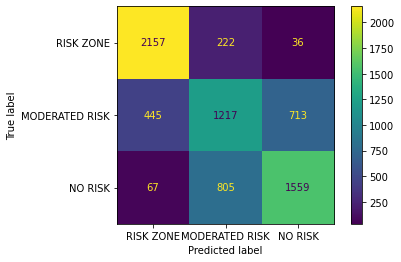

SVM
Accuracy score of training 0.685
Error rate of training 0.177
Accuracy score of test 0.683
Error rate of test 0.164
              precision    recall  f1-score   support

           1       0.81      0.89      0.85      2415
           2       0.54      0.51      0.53      2375
           3       0.68      0.64      0.66      2431

    accuracy                           0.68      7221
   macro avg       0.68      0.68      0.68      7221
weighted avg       0.68      0.68      0.68      7221



In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

classifier.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_svc_train=classifier.predict(X_train_tm_cs)

y_svc_test=classifier.predict(X_test_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_svc_test, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('SVM')
print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train_tm_c, y_svc_train))
print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_svc_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_svc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_svc_test))
print(metrics.classification_report(y_test_tm_c,y_svc_test))

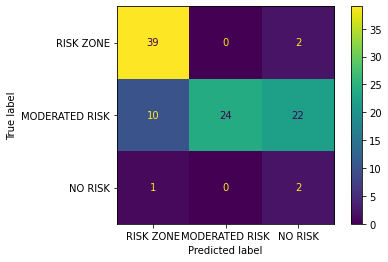

SVM
Accuracy score of validation 0.650
Error rate of validation 0.207


In [73]:
y_svc_valid=classifier.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_svc_valid, labels=classifier.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
disp.plot()
plt.show()
print('SVM')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c,  y_svc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c, y_svc_valid))

### Random Forest Classifier

In [74]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=5)

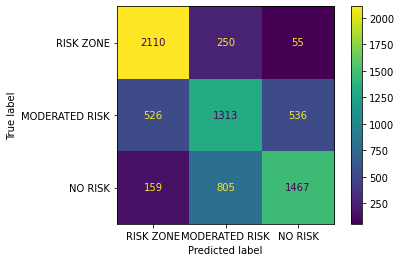

Random Forest Classifier
Accuracy score of test 0.974
Error rate of test 0.015
Accuracy score of test 0.677
Error rate of test 0.175
              precision    recall  f1-score   support

           1       0.75      0.87      0.81      2415
           2       0.55      0.55      0.55      2375
           3       0.71      0.60      0.65      2431

    accuracy                           0.68      7221
   macro avg       0.67      0.68      0.67      7221
weighted avg       0.67      0.68      0.67      7221



In [75]:
clf.fit(X_train_tm_cs,np.array(y_train_tm_c))
y_rfc_train=clf.predict(X_train_tm_cs)
y_rfc_test=clf.predict(X_test_tm_cs)
cm= confusion_matrix(y_test_tm_c, y_rfc_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Random Forest Classifier')
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_train_tm_c, y_rfc_train))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_rfc_train))

print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_rfc_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_rfc_test))

print(metrics.classification_report(y_test_tm_c,y_rfc_test))

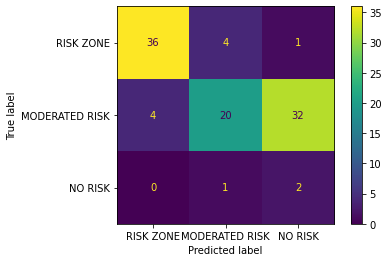

Random Forest Classifier
Accuracy score of validation 0.580
Error rate of validation 0.243
              precision    recall  f1-score   support

           1       0.90      0.88      0.89        41
           2       0.80      0.36      0.49        56
           3       0.06      0.67      0.11         3

    accuracy                           0.58       100
   macro avg       0.59      0.63      0.50       100
weighted avg       0.82      0.58      0.64       100



In [76]:
y_rfc_valid=clf.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_rfc_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[clf.classes_[0]],label_map[clf.classes_[1]],label_map[clf.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_rfc_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_rfc_valid))
print(metrics.classification_report(y_valid_c,y_rfc_valid))

### Naive bayes

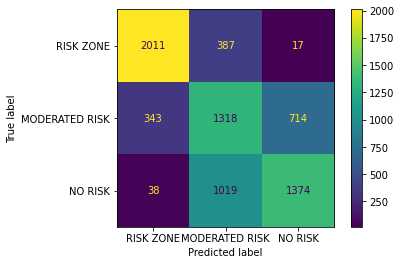

Guassian Naive Bayes
Accuracy score of train 0.634
Error rate of train 0.199
Accuracy score of test 0.651
Error rate of test 0.182
              precision    recall  f1-score   support

           1       0.84      0.83      0.84      2415
           2       0.48      0.55      0.52      2375
           3       0.65      0.57      0.61      2431

    accuracy                           0.65      7221
   macro avg       0.66      0.65      0.65      7221
weighted avg       0.66      0.65      0.65      7221



In [77]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_gnb_test= gnb.predict(X_test_tm_cs)
y_gnb_train= gnb.predict(X_train_tm_cs)


cm= confusion_matrix(y_test_tm_c, y_gnb_test, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('Guassian Naive Bayes')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_gnb_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_gnb_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_gnb_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_gnb_test))

print(metrics.classification_report(y_test_tm_c,y_gnb_test))

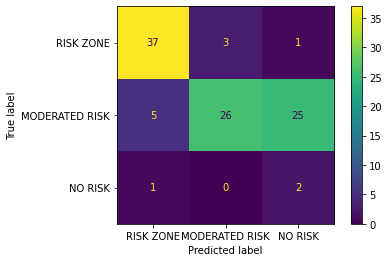

Random Forest Classifier
Accuracy score of validation 0.650
Error rate of validation 0.207
              precision    recall  f1-score   support

           1       0.86      0.90      0.88        41
           2       0.90      0.46      0.61        56
           3       0.07      0.67      0.13         3

    accuracy                           0.65       100
   macro avg       0.61      0.68      0.54       100
weighted avg       0.86      0.65      0.71       100



In [78]:
y_gnb_valid=gnb.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_gnb_valid, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[gnb.classes_[0]],label_map[gnb.classes_[1]],label_map[gnb.classes_[2]]])
disp.plot()
plt.show()
print('Random Forest Classifier')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_gnb_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_gnb_valid))
print(metrics.classification_report(y_valid_c,y_gnb_valid))


### KNN

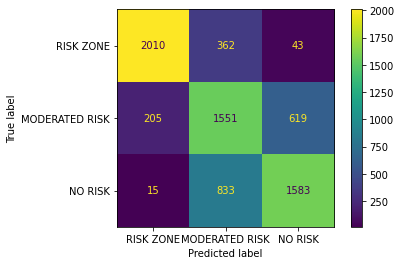

KNN
Accuracy score of train 0.717
Error rate of train 0.170
Accuracy score of test 0.712
Error rate of test 0.159
              precision    recall  f1-score   support

           1       0.90      0.83      0.87      2415
           2       0.56      0.65      0.61      2375
           3       0.71      0.65      0.68      2431

    accuracy                           0.71      7221
   macro avg       0.72      0.71      0.72      7221
weighted avg       0.72      0.71      0.72      7221



In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tm_cs,np.array(y_train_tm_c))

y_knn_test= knn.predict(X_test_tm_cs)
y_knn_train= knn.predict(X_train_tm_cs)

cm= confusion_matrix(y_test_tm_c, y_knn_test, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()

# Measure the performance
print('KNN')
print("Accuracy score of train %.3f" %metrics.accuracy_score(y_train_tm_c, y_knn_train))
print("Error rate of train %.3f" %mean_absolute_percentage_error(y_train_tm_c,y_knn_train))
print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test_tm_c, y_knn_test))
print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test_tm_c,y_knn_test))

print(metrics.classification_report(y_test_tm_c,y_knn_test))

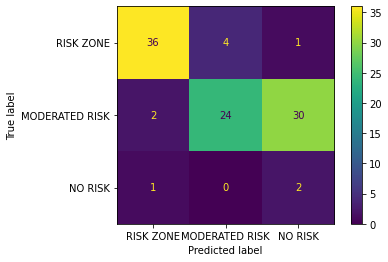

KNN
Accuracy score of validation 0.620
Error rate of validation 0.227
              precision    recall  f1-score   support

           1       0.92      0.88      0.90        41
           2       0.86      0.43      0.57        56
           3       0.06      0.67      0.11         3

    accuracy                           0.62       100
   macro avg       0.61      0.66      0.53       100
weighted avg       0.86      0.62      0.69       100



In [80]:
y_knn_valid=knn.predict(X_valid_s)
cm= confusion_matrix(y_valid_c, y_knn_valid, labels=knn.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[knn.classes_[0]],label_map[knn.classes_[1]],label_map[knn.classes_[2]]])
disp.plot()
plt.show()
print('KNN')
print("Accuracy score of validation %.3f" %metrics.accuracy_score(y_valid_c, y_knn_valid))
print("Error rate of validation %.3f" %mean_absolute_percentage_error(y_valid_c,y_knn_valid))
print(metrics.classification_report(y_valid_c,y_knn_valid))


Running cross validation on SVC (best model so far)

In [81]:
def transform_to_classes(d):
    y=[]
    for k in d:
        if k<=68:
            y.append(1)
        elif k>69 and k<=137:
            y.append(2)
        else:
            y.append(3)
    return y

Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    3    11    17 ... 20613 20614 20618]


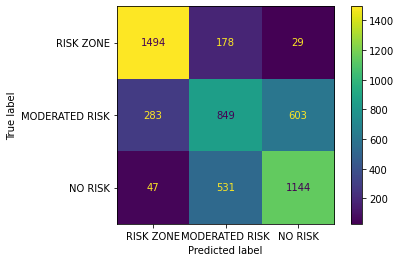

SVM
Accuracy score of training 0.689
Error rate of training 0.175
Accuracy score of test 0.676
Error rate of test 0.172
              precision    recall  f1-score   support

           1       0.82      0.88      0.85      1701
           2       0.54      0.49      0.52      1735
           3       0.64      0.66      0.65      1722

    accuracy                           0.68      5158
   macro avg       0.67      0.68      0.67      5158
weighted avg       0.67      0.68      0.67      5158

Index du train :  [    0     3     4 ... 20625 20627 20630] 

Index de test :  [    1     2     6 ... 20626 20628 20629]


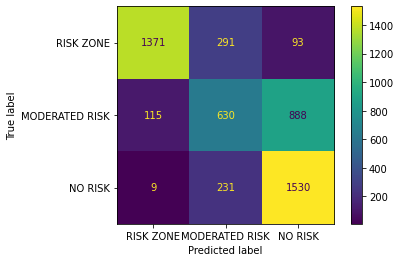

SVM
Accuracy score of training 0.687
Error rate of training 0.174
Accuracy score of test 0.685
Error rate of test 0.206
              precision    recall  f1-score   support

           1       0.92      0.78      0.84      1755
           2       0.55      0.39      0.45      1633
           3       0.61      0.86      0.71      1770

    accuracy                           0.68      5158
   macro avg       0.69      0.68      0.67      5158
weighted avg       0.69      0.68      0.68      5158

Index du train :  [    1     2     3 ... 20626 20628 20629] 

Index de test :  [    0    14    18 ... 20625 20627 20630]


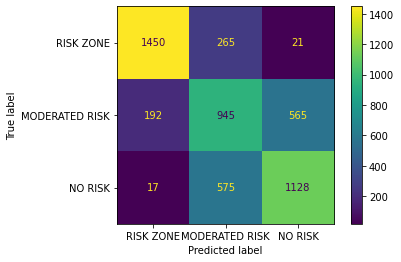

SVM
Accuracy score of training 0.688
Error rate of training 0.174
Accuracy score of test 0.683
Error rate of test 0.172
              precision    recall  f1-score   support

           1       0.87      0.84      0.85      1736
           2       0.53      0.56      0.54      1702
           3       0.66      0.66      0.66      1720

    accuracy                           0.68      5158
   macro avg       0.69      0.68      0.68      5158
weighted avg       0.69      0.68      0.69      5158

Index du train :  [    0     1     2 ... 20628 20629 20630] 

Index de test :  [    4     5     7 ... 20622 20623 20624]


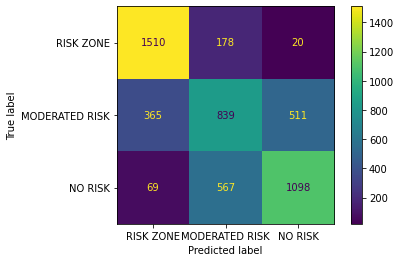

SVM
Accuracy score of training 0.689
Error rate of training 0.175
Accuracy score of test 0.668
Error rate of test 0.173
              precision    recall  f1-score   support

           1       0.78      0.88      0.83      1708
           2       0.53      0.49      0.51      1715
           3       0.67      0.63      0.65      1734

    accuracy                           0.67      5157
   macro avg       0.66      0.67      0.66      5157
weighted avg       0.66      0.67      0.66      5157



In [82]:
from sklearn.model_selection import KFold
train_tm_cv=dftm.drop(columns=['unit_number','RUL']).copy()
y=dftm['RUL']
cv = KFold(n_splits=4, shuffle=True)
for train_index, test_index in cv.split(train_tm) :
    print("Index du train : ", train_index, "\n")
    print("Index de test : ", test_index)
    X_train, X_test, y_train, y_test = train_tm_cv.iloc[train_index,:], train_tm_cv.iloc[test_index,:],np.array(transform_to_classes(y[train_index])), np.array(transform_to_classes(y[test_index]))
    classifier.fit(scaler.fit_transform(X_train), y_train)
    y_svc_train=classifier.predict(scaler.fit_transform(X_train))

    y_svc_test=classifier.predict(scaler.fit_transform(X_test))


    cm= confusion_matrix(y_test, y_svc_test, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[classifier.classes_[0]],label_map[classifier.classes_[1]],label_map[classifier.classes_[2]]])
    disp.plot()
    plt.show()

    # Measure the performance
    print('SVM')
    print("Accuracy score of training %.3f" %metrics.accuracy_score(y_train, y_svc_train))
    print("Error rate of training %.3f" %mean_absolute_percentage_error(y_train,y_svc_train))
    print("Accuracy score of test %.3f" %metrics.accuracy_score(y_test, y_svc_test))
    print("Error rate of test %.3f" %mean_absolute_percentage_error(y_test,y_svc_test))
    print(metrics.classification_report(y_test,y_svc_test))

Hence, SVR has appeared to be the best model.